<a href="https://colab.research.google.com/github/Rukayat-spec/Algorithmic-Trading-in-Forex-Machine-Learning-Approaches-for-GBP-EUR-Profitability/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [5]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 23.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [6]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [7]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [64]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import random
import tensorflow as tf
import keras_tuner as kt
import joblib  # For loading the models
from joblib import dump, load

In [9]:
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/MyDrive/Msc Project')

Mounted at /content/drive


**Load the CSV file into a DataFrame**


In [10]:
stock_data = pd.read_csv("GBP_EUR_Pair_Historical_Data.csv")
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-09-17,1.4271,1.4286,1.4237,1.4261,1.4261,0.0
1,2003-09-18,1.4261,1.4382,1.4239,1.4370,1.4370,0.0
2,2003-09-19,1.4368,1.4411,1.4333,1.4372,1.4372,0.0
3,2003-09-22,1.4354,1.4408,1.4331,1.4360,1.4360,0.0
4,2003-09-23,1.4360,1.4436,1.4341,1.4426,1.4426,0.0


In [11]:
# Check the shape of the dataset
print(f'The dataset contains {stock_data.shape[0]} rows and {stock_data.shape[1]} columns.')

The dataset contains 5402 rows and 7 columns.


In [12]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5402 entries, 0 to 5401
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5402 non-null   object 
 1   Open       5373 non-null   float64
 2   High       5373 non-null   float64
 3   Low        5373 non-null   float64
 4   Close      5373 non-null   float64
 5   Adj Close  5373 non-null   float64
 6   Volume     5373 non-null   float64
dtypes: float64(6), object(1)
memory usage: 295.5+ KB


In [13]:
# Display summary statistics
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.0
mean,1.242865,1.246882,1.238706,1.242842,1.242842,0.0
std,0.130321,0.130407,0.130163,0.130289,0.130289,0.0
min,1.015700,1.032400,1.015700,1.015700,1.015700,0.0
25%,1.145800,1.149510,1.141360,1.145690,1.145690,0.0
50%,1.181800,1.185800,1.177800,1.181700,1.181700,0.0
75%,1.350400,1.355800,1.344600,1.349400,1.349400,0.0
max,1.526200,1.529500,1.521400,1.526200,1.526200,0.0


In [14]:
# Display the sum of null values for each column
stock_data.isnull().sum()

Date          0
Open         29
High         29
Low          29
Close        29
Adj Close    29
Volume       29
dtype: int64

In [15]:
# Remove rows with null values in all columns
cleaned_stock_data = stock_data.dropna()

In [16]:
print(f'The dataset contains {cleaned_stock_data.shape[0]} rows and {cleaned_stock_data.shape[1]} columns.')

The dataset contains 5373 rows and 7 columns.


In [17]:
# Remove rows with missing values
cleaned_stock_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [18]:
cleaned_stock_data = cleaned_stock_data.drop(columns=['Adj Close','Volume'])
cleaned_stock_data

,Date,Open,High,Low,Close
0,2003-09-17,1.42710,1.42860,1.4237,1.42610
1,2003-09-18,1.42610,1.43820,1.4239,1.43700
2,2003-09-19,1.43680,1.44110,1.4333,1.43720
3,2003-09-22,1.43540,1.44080,1.4331,1.43600
4,2003-09-23,1.43600,1.44360,1.4341,1.44260
...,...,...,...,...,...
5397,2024-05-24,1.17370,1.17479,1.1718,1.17370
5398,2024-05-27,1.17380,1.17689,1.1735,1.17380
5399,2024-05-28,1.17581,1.17689,1.1738,1.17581
5400,2024-05-29,1.17562,1.17864,1.1741,1.17562


In [19]:
cleaned_stock_data.describe()

,Open,High,Low,Close
count,5373.000000,5373.000000,5373.000000,5373.000000
mean,1.242865,1.246882,1.238706,1.242842
std,0.130321,0.130407,0.130163,0.130289
min,1.015700,1.032400,1.015700,1.015700
25%,1.145800,1.149510,1.141360,1.145690
50%,1.181800,1.185800,1.177800,1.181700
75%,1.350400,1.355800,1.344600,1.349400
max,1.526200,1.529500,1.521400,1.526200


In [20]:
# Convert Date' column to datetime to ensure
cleaned_stock_data['Date'] = pd.to_datetime(cleaned_stock_data['Date'])
#df_cleaned.loc[:, 'Date'] = pd.to_datetime(cleaned_stock_data['Date'])
cleaned_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5373 entries, 0 to 5401
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5373 non-null   datetime64[ns]
 1   Open    5373 non-null   float64       
 2   High    5373 non-null   float64       
 3   Low     5373 non-null   float64       
 4   Close   5373 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 380.9 KB


**Using the box plot method to check for outliers in the dataset**

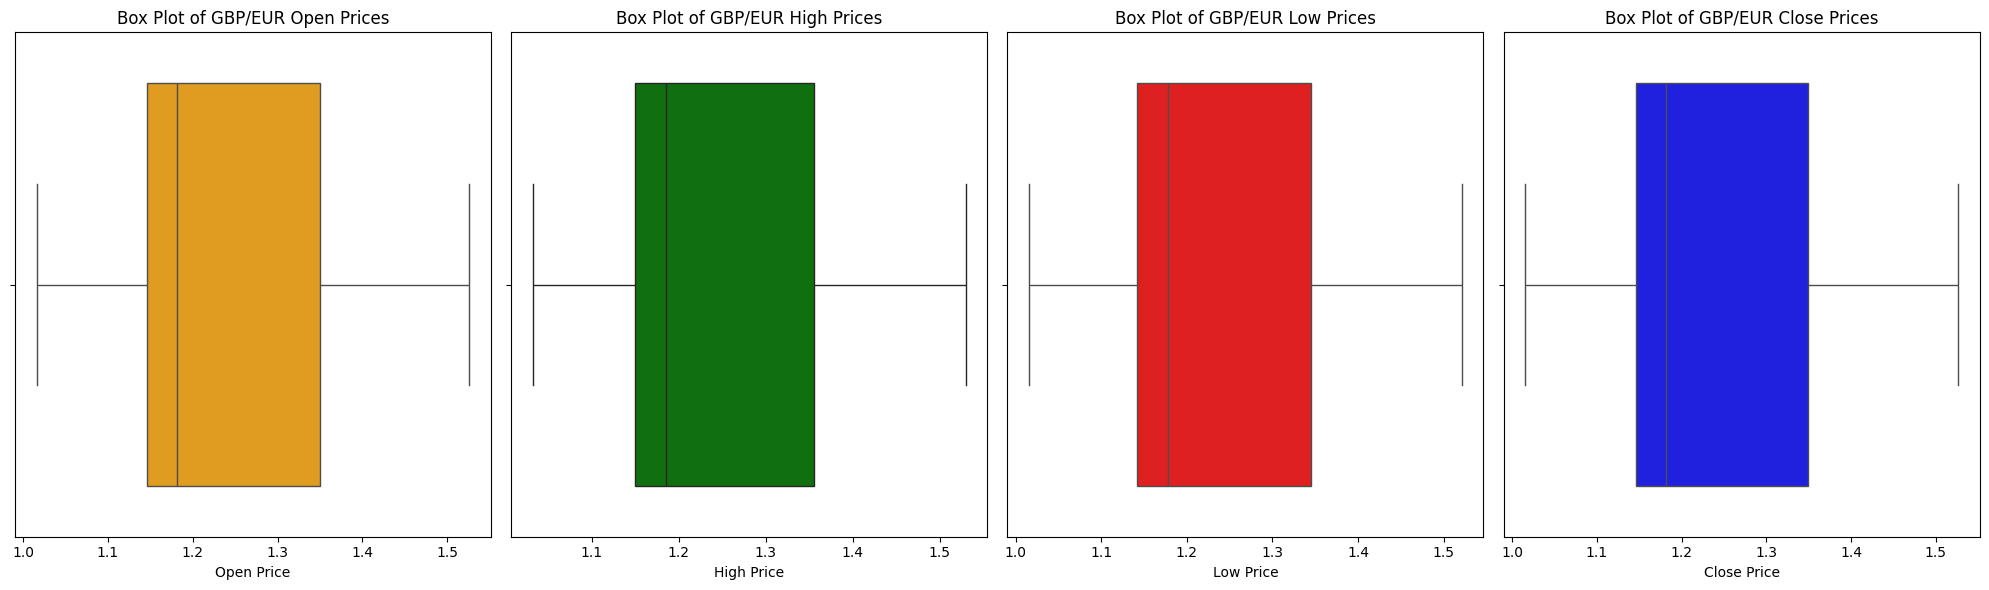

In [21]:

# Create a Sub DataFrame for the box plots
data_to_plot = cleaned_stock_data[['Open', 'High', 'Low', 'Close']]

# Create a figure with 4 horizontal box plots
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# box plot for 'Open' prices
sns.boxplot(data=data_to_plot['Open'], ax=axs[0], color='orange', orient='h')
axs[0].set_title('Box Plot of GBP/EUR Open Prices')
axs[0].set_xlabel('Open Price')

# box plot for 'High' prices
sns.boxplot(data=data_to_plot['High'], ax=axs[1], color='green', orient='h')
axs[1].set_title('Box Plot of GBP/EUR High Prices')
axs[1].set_xlabel('High Price')

# box plot for 'Low' prices
sns.boxplot(data=data_to_plot['Low'], ax=axs[2], color='red', orient='h')
axs[2].set_title('Box Plot of GBP/EUR Low Prices')
axs[2].set_xlabel('Low Price')

# box plot for 'Close' prices
sns.boxplot(data=data_to_plot['Close'], ax=axs[3], color='blue', orient='h')
axs[3].set_title('Box Plot of GBP/EUR Close Prices')
axs[3].set_xlabel('Close Price')

# adjust subplot parameters to give specified padding
plt.tight_layout()

# Show the plot
plt.show()


Box plots showing there is no outlier in any of the columns

**Visualizing the prices over the past 20 years to understand trends**

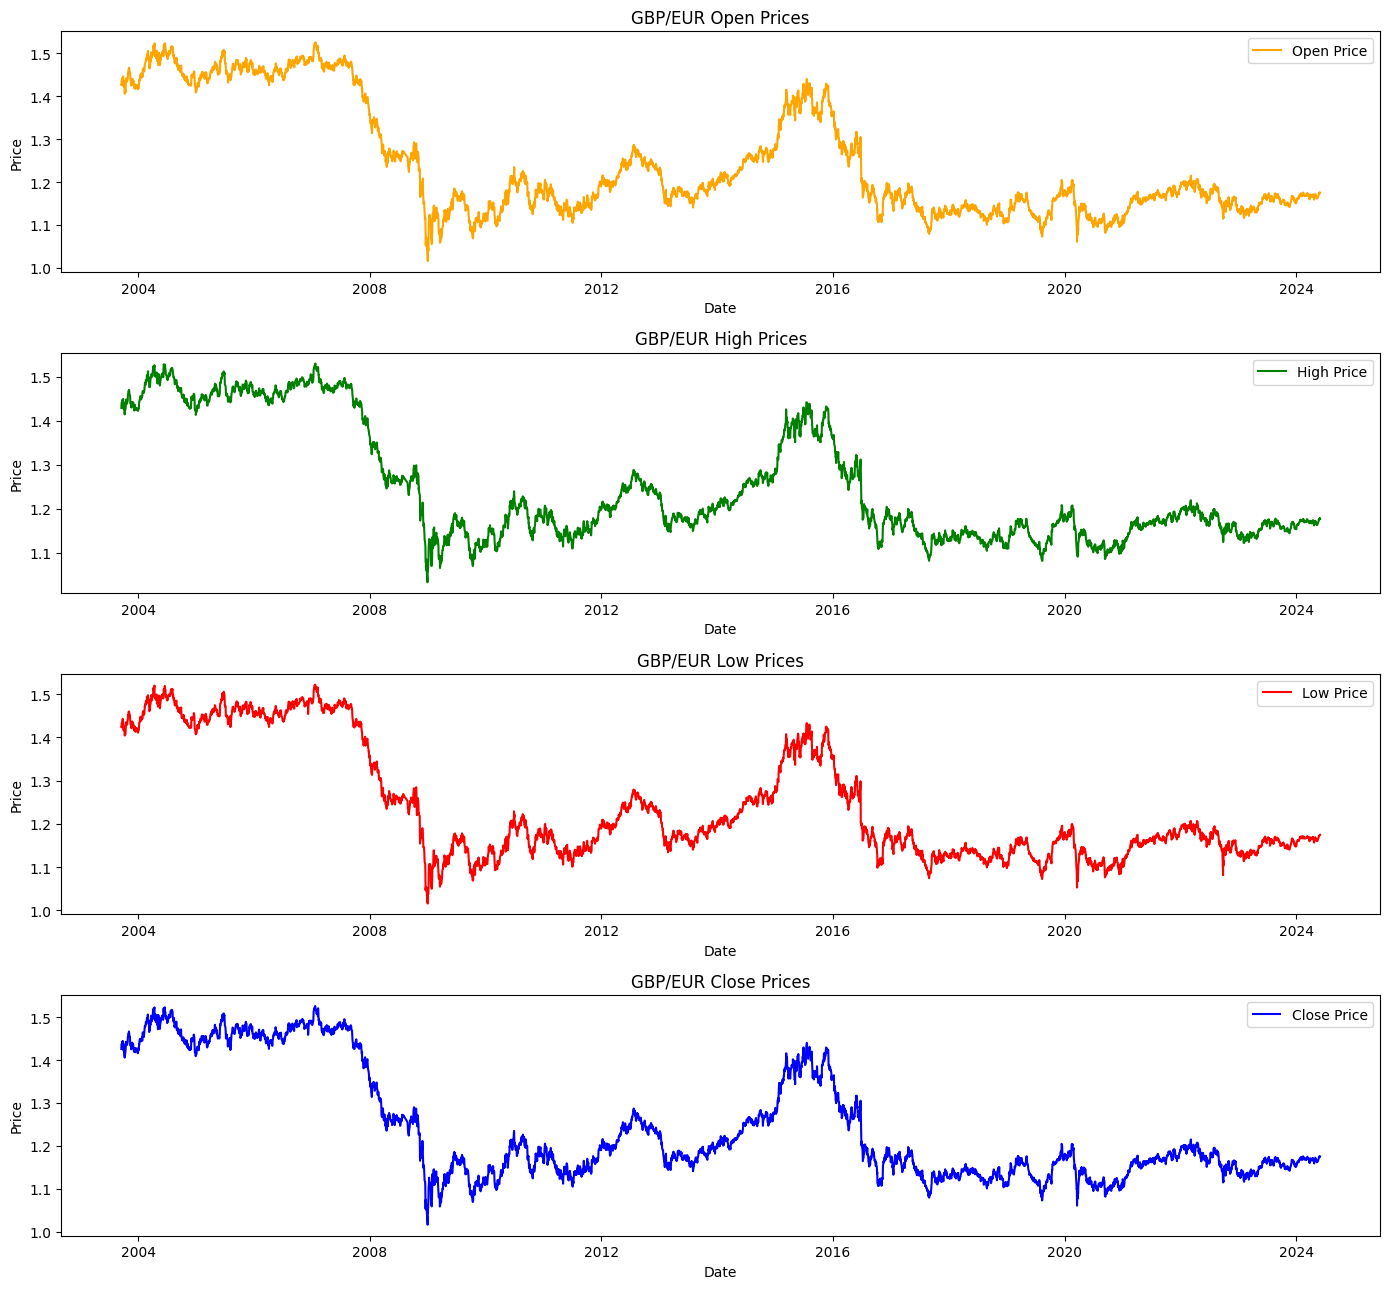

In [22]:
# Create a figure with 4 subplots without sharing x-axis
fig, axs = plt.subplots(4, 1, figsize=(14, 13), sharex=False)

# Plot 'Open' prices
axs[0].plot(cleaned_stock_data['Date'], cleaned_stock_data['Open'], label='Open Price', color='orange')
axs[0].set_title('GBP/EUR Open Prices')
axs[0].set_ylabel('Price')
axs[0].set_xlabel('Date')
axs[0].legend()

# Plot 'High' prices
axs[1].plot(cleaned_stock_data['Date'], cleaned_stock_data['High'], label='High Price', color='green')
axs[1].set_title('GBP/EUR High Prices')
axs[1].set_ylabel('Price')
axs[1].set_xlabel('Date')
axs[1].legend()

# Plot 'Low' prices
axs[2].plot(cleaned_stock_data['Date'], cleaned_stock_data['Low'], label='Low Price', color='red')
axs[2].set_title('GBP/EUR Low Prices')
axs[2].set_ylabel('Price')
axs[2].set_xlabel('Date')
axs[2].legend()

# Plot 'Close' prices
axs[3].plot(cleaned_stock_data['Date'], cleaned_stock_data['Close'], label='Close Price', color='blue')
axs[3].set_title('GBP/EUR Close Prices')
axs[3].set_ylabel('Price')
axs[3].set_xlabel('Date')
axs[3].legend()

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()

# Show the plot
plt.show()



All four plots show a similar pattern of price movement, indicating that the opening, high, low, and closing prices are correlated.
There are significant fluctuations in prices around the 2008 due to financial crisis. After 2016, there is a notable downward trend, followed by a stabilization in recent years.
The charts highlighting the substantial impact of the global financial turmoil on the GBP/EUR currency pair.

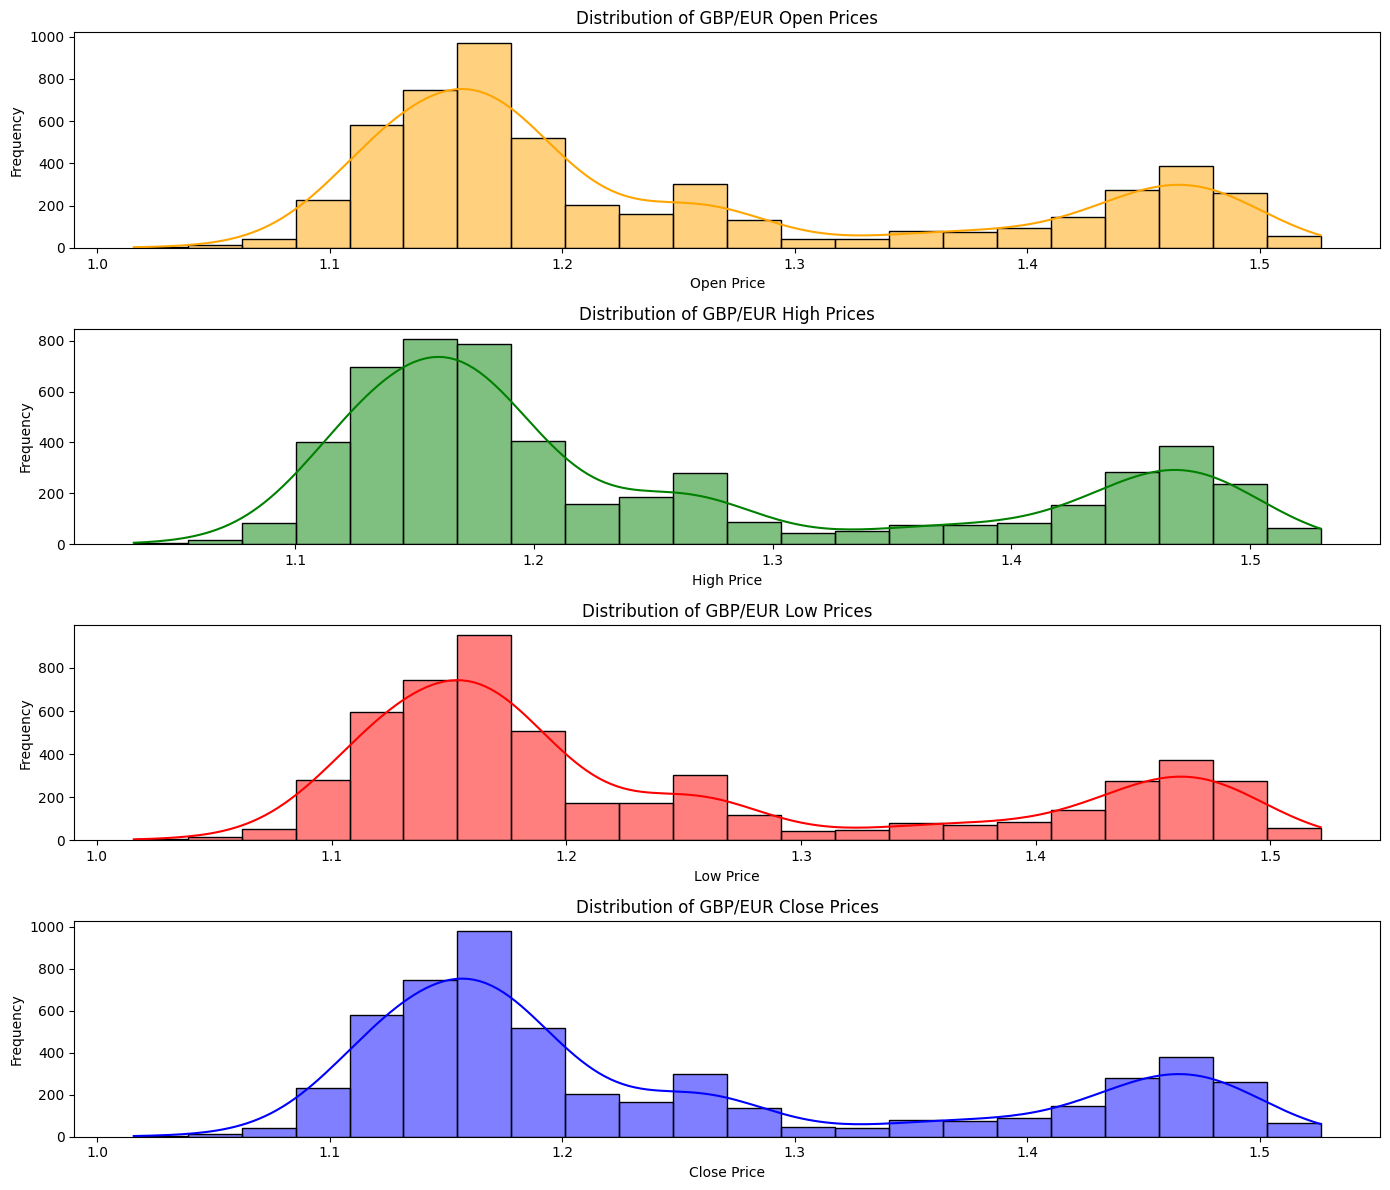

In [23]:
# using histogram to understand the distribution of prices of interest, Open, High, Low and Close.
"""Kernel Density Estimate(KDE) adds a smooth curve over the histogram, giving a
 continuous estimation of the probability density function of the data """

# Figure for the subplots
fig, axs = plt.subplots(4, 1, figsize=(14, 12))
# Plot histogram for 'Open' prices
sns.histplot(cleaned_stock_data['Open'], kde=True, ax=axs[0], color='orange')
axs[0].set_title('Distribution of GBP/EUR Open Prices')
axs[0].set_xlabel('Open Price')
axs[0].set_ylabel('Frequency')

# Plot histogram for 'High' prices
sns.histplot(cleaned_stock_data['High'], kde=True, ax=axs[1], color='green')
axs[1].set_title('Distribution of GBP/EUR High Prices')
axs[1].set_xlabel('High Price')
axs[1].set_ylabel('Frequency')

# Plot histogram for 'Low' prices
sns.histplot(cleaned_stock_data['Low'], kde=True, ax=axs[2], color='red')
axs[2].set_title('Distribution of GBP/EUR Low Prices')
axs[2].set_xlabel('Low Price')
axs[2].set_ylabel('Frequency')

# Plot histogram for 'Close' prices
sns.histplot(cleaned_stock_data['Close'], kde=True, ax=axs[3], color='blue')
axs[3].set_title('Distribution of GBP/EUR Close Prices')
axs[3].set_xlabel('Close Price')
axs[3].set_ylabel('Frequency')

# adjust subplot parameters to give specified padding
plt.tight_layout()

# Show the plot
plt.show()


All histograms show a bimodal distribution(2 peaks)

The first peak is between 1.1 and 1.2 and is slightly skewed to the right.
The second peak is between 1.4 and 1.5 and appears to be more symmetric(tending to be normally distributed).

**Feature Engineering**

**Adding technical indicators to better understand market dynamics and make informed trading decisions.**

In [24]:
# Exponential Moving Average(EMA)

def calculate_ema(df, span):
    """
    Calculate the Exponential Moving Average (EMA).

    Parameters:
    df (pandas DataFrame): The original dataframe.
    span (int): The span for the EMA.

    Returns:
    pandas Series: The EMA of the close prices.
    """
    return df['Close'].ewm(span=span, adjust=False).mean()

# Calculate EMA 50 and EMA 200
cleaned_stock_data.loc[:,'EMA_50'] = calculate_ema(cleaned_stock_data, span=50)
cleaned_stock_data.loc[:,'EMA_200'] = calculate_ema(cleaned_stock_data, span=200)



# Moving average convergence/divergence (MACD)
def calculate_macd(df, short_span=12, long_span=26, signal_span=9):
    """
    Calculate the MACD, Signal Line, and MACD Histogram.

    Parameters:
    df (pandas DataFrame): The original dataframe.
    short_span (int): The span for the short-term EMA.
    long_span (int): The span for the long-term EMA.
    signal_span (int): The span for the Signal line.

    Returns:
    pandas DataFrame: The MACD, Signal line, and MACD Histogram.
    """
    short_ema = df['Close'].ewm(span=short_span, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_span, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_span, adjust=False).mean()
    macd_histogram = macd - signal
    return pd.DataFrame({'MACD': macd, 'Signal': signal, 'MACD_Histogram': macd_histogram})

# Calculate MACD, Signal Line, and MACD Histogram
macd_df = calculate_macd(cleaned_stock_data)

# Add these components to the original DataFrame
cleaned_stock_data.loc[:,'MACD'] = macd_df['MACD']
cleaned_stock_data.loc[:, 'MACD_Signal'] = macd_df['Signal']
cleaned_stock_data.loc[:,'MACD_Histogram'] = macd_df['MACD_Histogram']



# Relative Strength Index (RSI)
def calculate_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Assuming df_cleaned is already loaded and includes EMA and MACD calculations
cleaned_stock_data.loc[:,'RSI'] = calculate_rsi(cleaned_stock_data)



#Average Directional Index (ADX)
def calculate_adx(df, window=14):
    """
    Calculate the Average Directional Index (ADX).

    Parameters:
    df (pandas DataFrame): The original dataframe.
    window (int): The period for calculating the ADX.

    Returns:
    pandas DataFrame: The ADX, plus directional indicator (DI+), and minus directional indicator (DI-).
    """
    high = df['High']
    low = df['Low']
    close = df['Close']

    # Calculate True Range (TR)
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # Calculate directional movements
    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    # Smooth the TR, plus_dm, and minus_dm
    atr = tr.rolling(window=window, min_periods=1).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/window).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/window).mean() / atr))

    # Calculate the DX and ADX
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.ewm(alpha=1/window).mean()

    return pd.DataFrame({'ADX': adx, 'Plus_DI': plus_di, 'Minus_DI': minus_di})

# Calculate ADX, Plus_DI, and Minus_DI
adx_df = calculate_adx(cleaned_stock_data)

# Add these components to the original DataFrame
cleaned_stock_data.loc[:,'ADX'] = adx_df['ADX']
cleaned_stock_data.loc[:,'Plus_DI'] = adx_df['Plus_DI']
cleaned_stock_data.loc[:,'Minus_DI'] = adx_df['Minus_DI']

# Drop rows with NaN values (if any) at the beginning of the dataset
cleaned_stock_data.dropna(inplace=True)


# Display the first few rows of the DataFrame to verify
cleaned_stock_data.shape




(5360, 14)

**Filtering the data set to the last three years for better visualisation of the indicators **

In [25]:
# Filter data for the past three years
three_years_prices = cleaned_stock_data['Date'].max() - pd.DateOffset(years=3)
df_last_three_years = cleaned_stock_data[cleaned_stock_data['Date'] >= three_years_prices]
df_last_three_years.head()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
4618,2021-05-31,1.16310,1.16388,1.16050,1.16314,1.157217,1.139960,0.001130,0.000848,0.000283,48.898116,12.151276,26.123530,19.765260
4619,2021-06-01,1.16282,1.16447,1.15640,1.16296,1.157443,1.140189,0.001270,0.000932,0.000338,48.553259,11.503596,24.085034,22.644024
4620,2021-06-02,1.15846,1.16265,1.15757,1.15853,1.157485,1.140372,0.001012,0.000948,0.000064,42.171717,10.902179,22.123734,20.800069
4621,2021-06-03,1.16063,1.16453,1.15985,1.16056,1.157606,1.140572,0.000960,0.000951,0.000010,46.675787,10.713689,22.580354,19.133413
4622,2021-06-04,1.16288,1.16733,1.16250,1.16300,1.157817,1.140796,0.001103,0.000981,0.000122,53.483269,11.056005,23.667516,17.313026


**Plots of the different technical indicators used in the study**

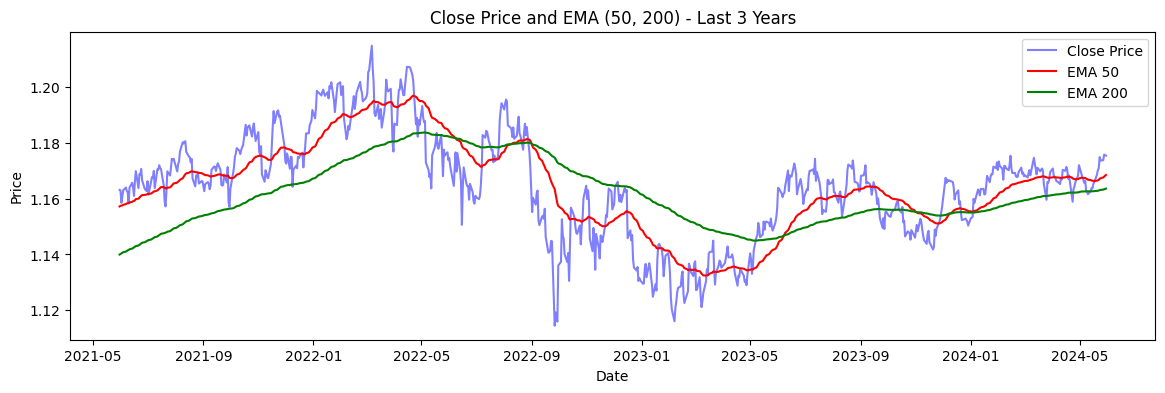

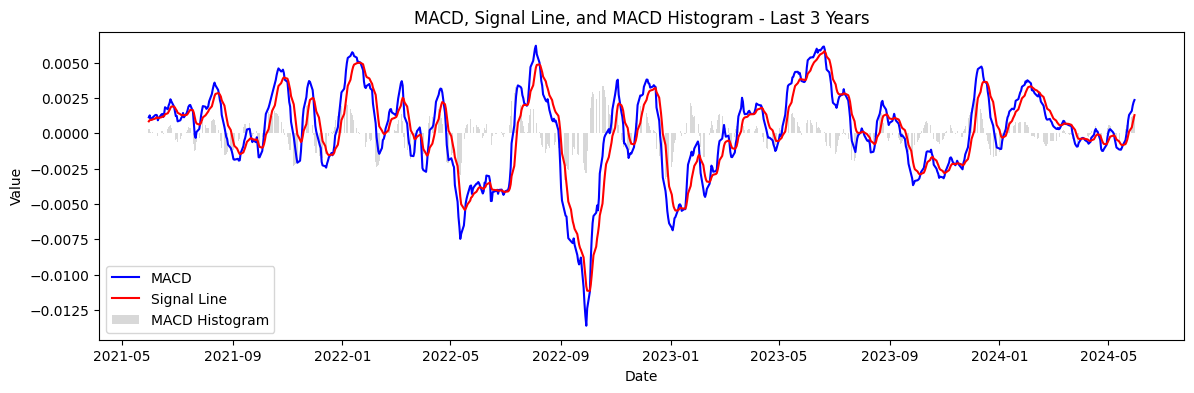

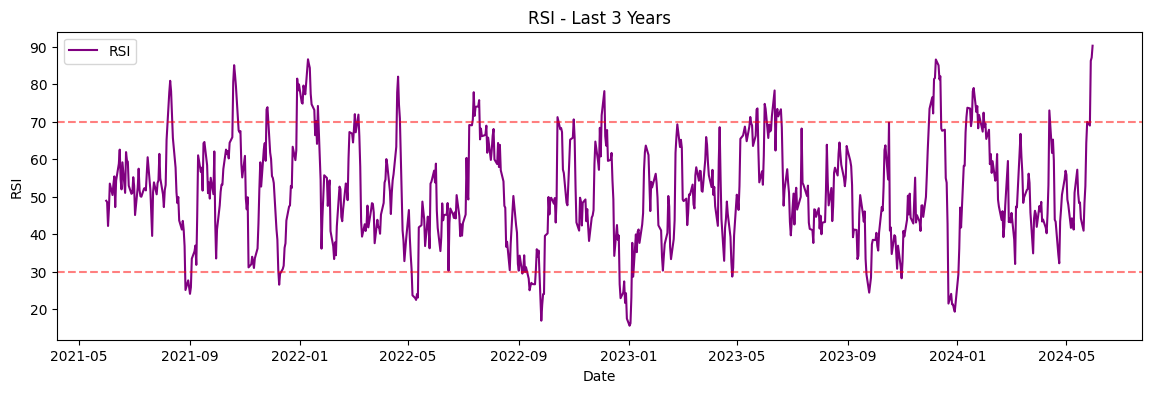

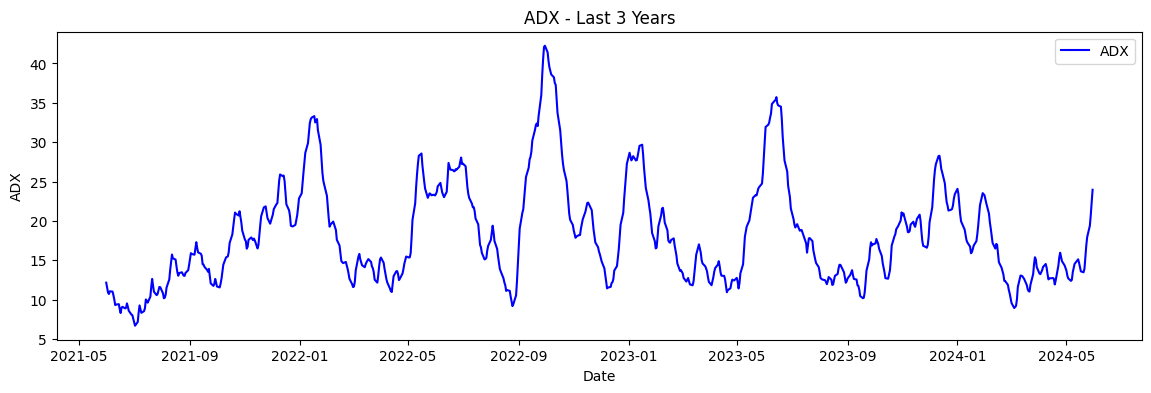

In [26]:
# Plot EMA
def plot_ema(df):
    """
    Plot the closing price along with EMA 50 and EMA 200.

    Parameters:
    df (DataFrame): DataFrame with 'Date', 'Close', 'EMA_50', and 'EMA_200' columns.
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df['Date'], df['Close'], label='Close Price', color='blue', alpha=0.5)
    plt.plot(df['Date'], df['EMA_50'], label='EMA 50', color='red')
    plt.plot(df['Date'], df['EMA_200'], label='EMA 200', color='green')
    plt.title('Close Price and EMA (50, 200) - Last 3 Years')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_ema(df_last_three_years)

# Plot MACD
def plot_macd(df):
    """
    Plot MACD, Signal Line, and MACD Histogram.

    Parameters:
    df (DataFrame): DataFrame with 'Date', 'MACD', 'MACD_Signal', and 'MACD_Histogram' columns.
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df['Date'], df['MACD'], label='MACD', color='blue')
    plt.plot(df['Date'], df['MACD_Signal'], label='Signal Line', color='red')
    plt.bar(df['Date'], df['MACD_Histogram'], label='MACD Histogram', color='gray', alpha=0.3)
    plt.title('MACD, Signal Line, and MACD Histogram - Last 3 Years')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_macd(df_last_three_years)

# Plot RSI
def plot_rsi(df):
    """
    Plot the RSI with overbought and oversold lines.

    Parameters:
    df (DataFrame): DataFrame with 'Date' and 'RSI' columns.
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df['Date'], df['RSI'], label='RSI', color='purple')
    plt.axhline(30, linestyle='--', alpha=0.5, color='red')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')
    plt.title('RSI - Last 3 Years')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()

plot_rsi(df_last_three_years)

# Plot ADX
def plot_adx(df):
    """
    Plot the ADX.

    Parameters:
    df (DataFrame): DataFrame with 'Date' and 'ADX' columns.
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df['Date'], df['ADX'], label='ADX', color='blue')
    #plt.plot(df['Date'], df['Plus_DI'], label='Plus DI', color='green')
    #plt.plot(df['Date'], df['Minus_DI'], label='Minus DI', color='red')
    plt.title('ADX - Last 3 Years')
    plt.xlabel('Date')
    plt.ylabel('ADX')
    plt.legend()
    plt.show()

plot_adx(df_last_three_years)


In [27]:
indicators = cleaned_stock_data[['Open','High', 'Low', 'Close', 'EMA_50', 'EMA_200', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'ADX', 'Plus_DI', 'Minus_DI']]

# Calculate the correlation matrix
correlation_matrix = indicators.corr()

# Display the correlation matrix
correlation_matrix


,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
Open,1.000000,0.999575,0.999504,0.999599,0.989441,0.955766,0.106554,0.111503,0.007085,0.067560,0.083503,0.042413,-0.057127
High,0.999575,1.000000,0.999338,0.999564,0.989732,0.956914,0.102799,0.107504,0.007042,0.066714,0.087726,0.045250,-0.059134
Low,0.999504,0.999338,1.000000,0.999531,0.988697,0.954224,0.108630,0.113200,0.008630,0.070012,0.079412,0.047265,-0.062775
Close,0.999599,0.999564,0.999531,1.000000,0.989092,0.955349,0.107607,0.111537,0.010316,0.071408,0.082768,0.045733,-0.060480
EMA_50,0.989441,0.989732,0.988697,0.989092,1.000000,0.979773,-0.029805,-0.011962,-0.058905,-0.037607,0.129580,-0.054184,0.044490
EMA_200,0.955766,0.956914,0.954224,0.955349,0.979773,1.000000,-0.111594,-0.109808,-0.028051,-0.066882,0.170346,-0.076282,0.099267
MACD,0.106554,0.102799,0.108630,0.107607,-0.029805,-0.111594,1.000000,0.948852,0.355415,0.687510,-0.325195,0.608050,-0.633788
MACD_Signal,0.111503,0.107504,0.113200,0.111537,-0.011962,-0.109808,0.948852,1.000000,0.042129,0.495578,-0.335454,0.480071,-0.523278
MACD_Histogram,0.007085,0.007042,0.008630,0.010316,-0.058905,-0.028051,0.355415,0.042129,1.000000,0.708469,-0.035965,0.502925,-0.456454
RSI,0.067560,0.066714,0.070012,0.071408,-0.037607,-0.066882,0.687510,0.495578,0.708469,1.000000,-0.146697,0.678265,-0.657802


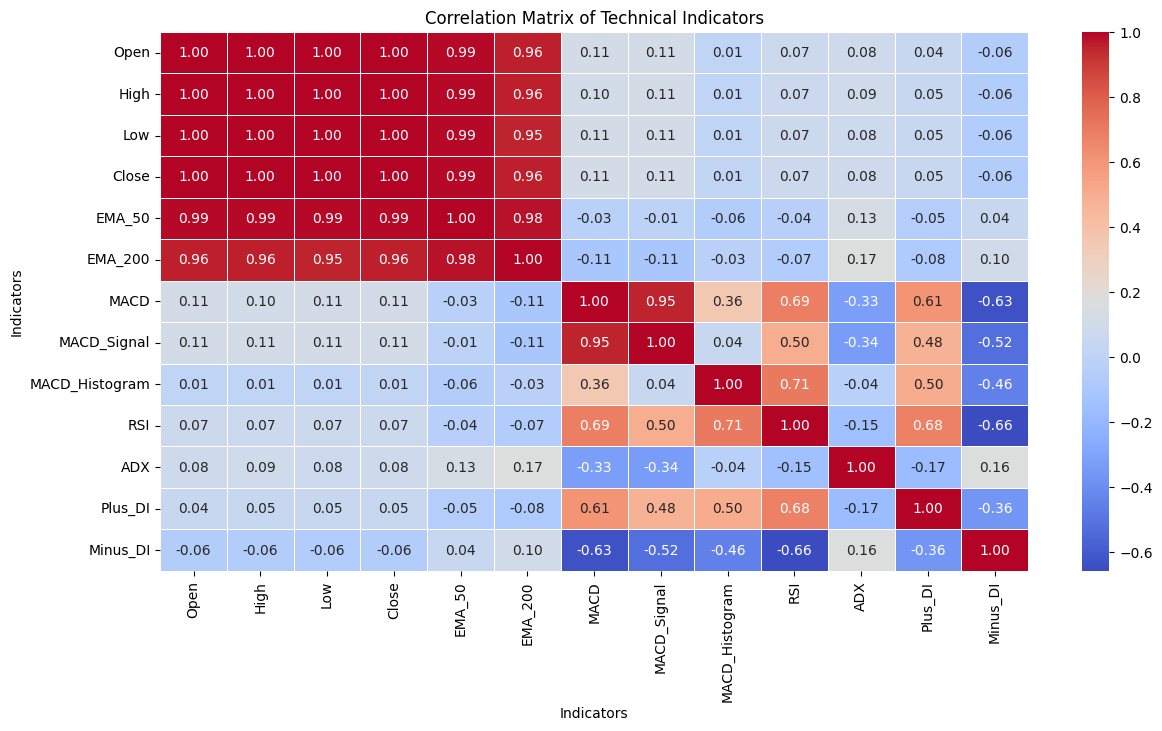

In [28]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 7))

# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add titles and labels
plt.title('Correlation Matrix of Technical Indicators')
plt.xlabel('Indicators')
plt.ylabel('Indicators')

# Show the plot
plt.show()


Recommending indicators combinations based on the correlation matrix

High Correlation: Indicators that are highly correlated often provide similar information about the market. Using multiple highly correlated indicators can lead to redundancy, making your strategy less effective

Low or Negative Correlation: Indicators with low or negative correlation can provide different perspectives on the market. Combining such indicators can create a more robust strategy.

EMA 50 and EMA 200:

EMA 50: Represents medium-term trends.
EMA 200: Very long-term trend indicator, useful for identifying the overall market direction.

Generate buy/sell signals based on EMA crossover and RSI

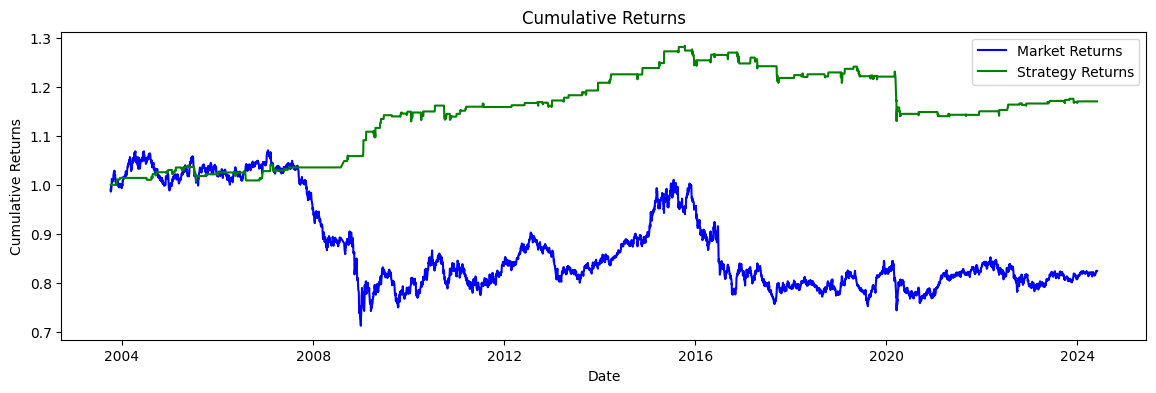

In [29]:
def generate_signals(df):
    """
    Generate trading signals based on EMA and RSI.

    Parameters:
    df (DataFrame): DataFrame with 'EMA_50', 'EMA_200', 'RSI', and 'Close' columns.

    Returns:
    DataFrame: DataFrame with an added 'Signal' column (1 for buy, -1 for sell, 0 otherwise).
    """
    df['Signal'] = 0
    df.loc[(df['EMA_50'] > df['EMA_200']) & (df['RSI'] < 30), 'Signal'] = 1
    df.loc[(df['EMA_50'] < df['EMA_200']) & (df['RSI'] > 70), 'Signal'] = -1
    return df

# Generate signals
cleaned_stock_data = generate_signals(cleaned_stock_data)

# Calculate returns
cleaned_stock_data['Returns'] = cleaned_stock_data['Close'].pct_change()
cleaned_stock_data['Strategy_Returns'] = cleaned_stock_data['Signal'].shift(1) * cleaned_stock_data['Returns']

# Calculate cumulative returns
cleaned_stock_data['Cumulative_Strategy_Returns'] = (1 + cleaned_stock_data['Strategy_Returns']).cumprod()
cleaned_stock_data['Cumulative_Market_Returns'] = (1 + cleaned_stock_data['Returns']).cumprod()

# Plot the market and strategy cumulative returns
plt.figure(figsize=(14, 4))
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Market_Returns'], label='Market Returns', color='blue')
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='green')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


Observations:

The strategy appears to perform significantly better than the market returns, particularly after 2008.
The strategy returns show a more stable and upward trend compared to the volatile market returns.
There are periods where the strategy returns are flat, indicating no trades were made during those times, likely because the conditions for the signals were not met.
The cumulative returns of the strategy show a steady increase, suggesting that the strategy was effective in capturing profitable trading opportunities and avoiding significant losses during market downturns.

Comparison and Insights:

Performance: The strategy returns consistently outperform the market returns, indicating that the trading strategy based on EMA (50, 200) and RSI has been effective in generating positive returns.
Risk Management: The strategy seems to manage risk better than the buy-and-hold approach, avoiding major downturns and achieving more stable growth.
Volatility: The market returns exhibit high volatility, whereas the strategy returns are smoother and show less fluctuation.
The use of EMA (50, 200) and RSI indicators has provided a robust trading strategy that outperforms the market returns over the period analyzed. This suggests that combining trend-following indicators (EMA crossover) with momentum indicators (RSI) can lead to a more effective trading strategy in the GBP/EUR forex market

Generate buy/sell signals based on EMA crossover, RSI and ADX

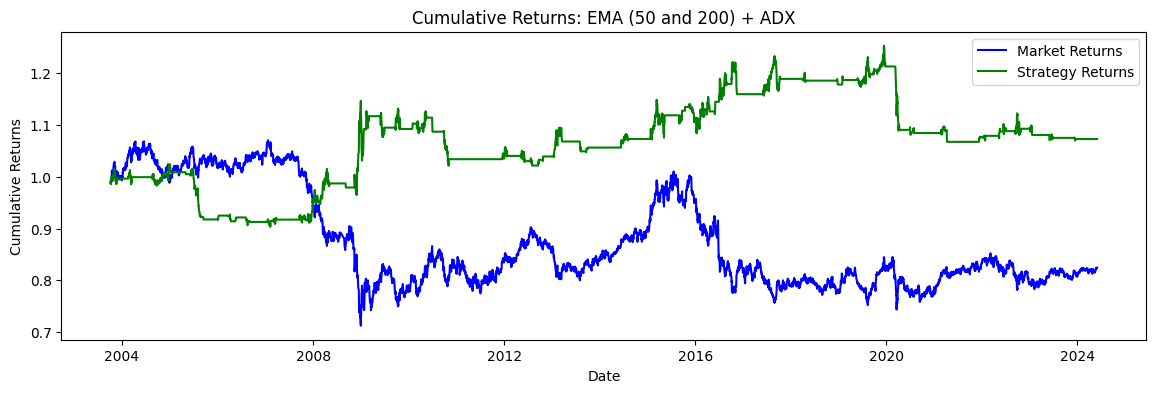

In [30]:
def generate_signals_ema_adx(df):
    """
    Generate trading signals based on EMA and ADX.

    Parameters:
    df (DataFrame): DataFrame with 'EMA_50', 'EMA_200', 'ADX', and 'Close' columns.

    Returns:
    DataFrame: DataFrame with an added 'Signal' column (1 for buy, -1 for sell, 0 otherwise).
    """
    df['Signal'] = 0
    df.loc[(df['EMA_50'] > df['EMA_200']) & (df['ADX'] > 25), 'Signal'] = 1
    df.loc[(df['EMA_50'] < df['EMA_200']) & (df['ADX'] > 25), 'Signal'] = -1
    return df

# Generate signals
cleaned_stock_data = generate_signals_ema_adx(cleaned_stock_data)

# Calculate returns
cleaned_stock_data['Returns'] = cleaned_stock_data['Close'].pct_change()
cleaned_stock_data['Strategy_Returns'] = cleaned_stock_data['Signal'].shift(1) * cleaned_stock_data['Returns']

# Calculate cumulative returns
cleaned_stock_data['Cumulative_Strategy_Returns'] = (1 + cleaned_stock_data['Strategy_Returns']).cumprod()
cleaned_stock_data['Cumulative_Market_Returns'] = (1 + cleaned_stock_data['Returns']).cumprod()

# Plot the market and strategy cumulative returns
plt.figure(figsize=(14, 4))
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Market_Returns'], label='Market Returns', color='blue')
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='green')
plt.title('Cumulative Returns: EMA (50 and 200) + ADX')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()



Observations:

The strategy returns show a more stable and upward trend compared to the volatile market returns.
The strategy appears to avoid major downturns, indicating effective risk management by not participating in trades during weaker trends (as indicated by ADX).
The cumulative returns from the strategy exhibit fewer fluctuations and more consistent growth, suggesting the combination of EMA, RSI, and ADX is effective in identifying profitable trades and avoiding significant losses.

Comparison and Insights:

Performance: The strategy returns consistently outperform the market returns, indicating that the combined use of EMA, RSI, and ADX has been effective in generating positive returns and managing risk.
Risk Management: The strategy's ability to avoid major declines seen in the market returns suggests strong risk management. The ADX helps in avoiding trades during weak trends, while the EMA and RSI help in capturing profitable trends.
Volatility: The market returns exhibit high volatility and significant drawdowns, whereas the strategy returns are smoother and show more stable growth.

Generate buy/sell signals based on EMA crossover and ADX

Entry Signal: When the EMA 50 crosses above EMA 200 and ADX is above 25 (indicating a strong trend), consider entering a long position. Conversely, when EMA 50 crosses below EMA 200 and ADX is above 25, consider a short position.

Exit Signal: Exit when the ADX falls below 20, indicating a weakening trend, or when there is a reverse crossover of the EMAs.

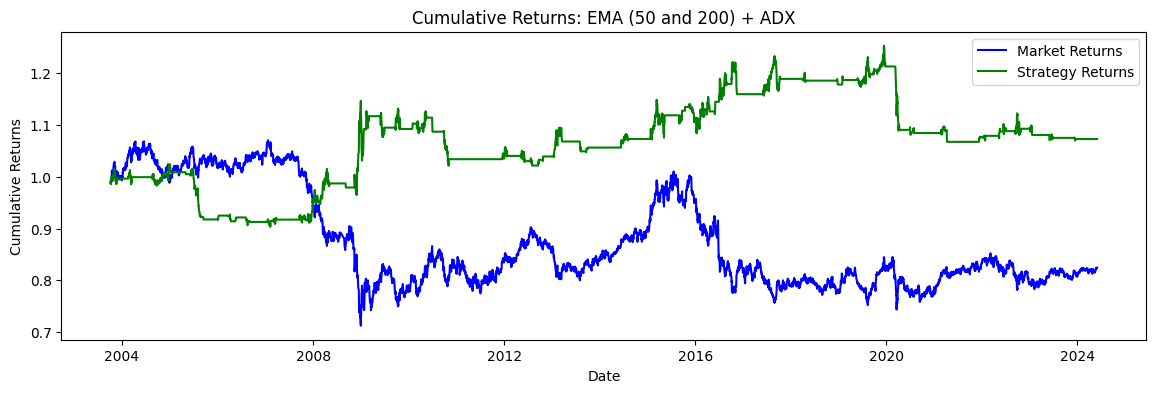

In [31]:
import matplotlib.pyplot as plt

def generate_signals_ema_adx(df):
    """
    Generate trading signals based on EMA and ADX.

    Parameters:
    df (DataFrame): DataFrame with 'EMA_50', 'EMA_200', 'ADX', and 'Close' columns.

    Returns:
    DataFrame: DataFrame with an added 'Signal' column (1 for buy, -1 for sell, 0 otherwise).
    """
    df['Signal'] = 0
    df.loc[(df['EMA_50'] > df['EMA_200']) & (df['ADX'] > 25), 'Signal'] = 1
    df.loc[(df['EMA_50'] < df['EMA_200']) & (df['ADX'] > 25), 'Signal'] = -1
    return df

# Generate signals
cleaned_stock_data = generate_signals_ema_adx(cleaned_stock_data)

# Calculate returns
cleaned_stock_data['Returns'] = cleaned_stock_data['Close'].pct_change()
cleaned_stock_data['Strategy_Returns'] = cleaned_stock_data['Signal'].shift(1) * cleaned_stock_data['Returns']

# Calculate cumulative returns
cleaned_stock_data['Cumulative_Strategy_Returns'] = (1 + cleaned_stock_data['Strategy_Returns']).cumprod()
cleaned_stock_data['Cumulative_Market_Returns'] = (1 + cleaned_stock_data['Returns']).cumprod()

# Plot the market and strategy cumulative returns
plt.figure(figsize=(14, 4))
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Market_Returns'], label='Market Returns', color='blue')
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='green')
plt.title('Cumulative Returns: EMA (50 and 200) + ADX')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()




Generate buy/sell signals based on RSI and Plus/Minus DI

Entry Signal: Look for long positions when RSI is below 30 (oversold) and Plus_DI is above Minus_DI (indicating upward momentum). For short positions, look for RSI above 70 (overbought) and Minus_DI above Plus_DI (indicating downward momentum).

Exit Signal: Exit when RSI returns to the neutral zone (40-60) or when the directional indicators reverse their positions.

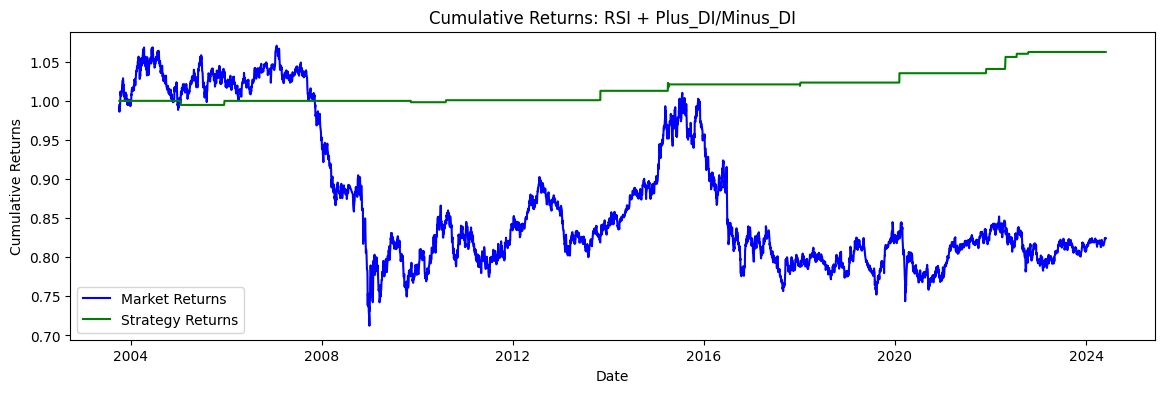

In [32]:
def generate_signals_rsi_di(df):
    """
    Generate trading signals based on RSI and Directional Indicators.

    Parameters:
    df (DataFrame): DataFrame with 'RSI', 'Plus_DI', 'Minus_DI', and 'Close' columns.

    Returns:
    DataFrame: DataFrame with an added 'Signal' column (1 for buy, -1 for sell, 0 otherwise).
    """
    df['Signal'] = 0
    df.loc[(df['RSI'] < 30) & (df['Plus_DI'] > df['Minus_DI']), 'Signal'] = 1
    df.loc[(df['RSI'] > 70) & (df['Minus_DI'] > df['Plus_DI']), 'Signal'] = -1
    return df

# Generate signals
cleaned_stock_data = generate_signals_rsi_di(cleaned_stock_data)

# Calculate returns
cleaned_stock_data['Returns'] = cleaned_stock_data['Close'].pct_change()
cleaned_stock_data['Strategy_Returns'] = cleaned_stock_data['Signal'].shift(1) * cleaned_stock_data['Returns']

# Calculate cumulative returns
cleaned_stock_data['Cumulative_Strategy_Returns'] = (1 + cleaned_stock_data['Strategy_Returns']).cumprod()
cleaned_stock_data['Cumulative_Market_Returns'] = (1 + cleaned_stock_data['Returns']).cumprod()

# Plot Plot the market and strategy cumulative returns
plt.figure(figsize=(14, 4))
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Market_Returns'], label='Market Returns', color='blue')
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='green')
plt.title('Cumulative Returns: RSI + Plus_DI/Minus_DI')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()



Generate buy/sell signals based on MACD and RSI

Entry Signal: Consider entering a long position when the MACD line crosses above the signal line and the RSI is below 30 (oversold) moving upwards. For short positions, look for the MACD line crossing below the signal line and RSI above 70 (overbought) moving downwards.

Exit Signal: Exit when the MACD histogram starts to show divergence from the MACD line, or when RSI approaches the neutral zone

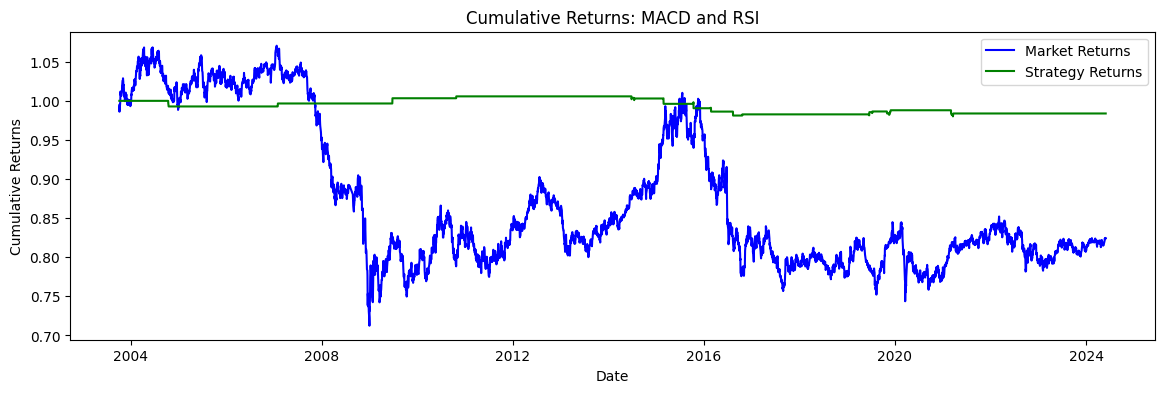

In [33]:
def generate_signals_macd_rsi(df):
    """
    Generate trading signals based on MACD and RSI.

    Parameters:
    df (DataFrame): DataFrame with 'MACD', 'MACD_Signal', 'RSI', and 'Close' columns.

    Returns:
    DataFrame: DataFrame with an added 'Signal' column (1 for buy, -1 for sell, 0 otherwise).
    """
    df['Signal'] = 0
    df.loc[(df['MACD'] > df['MACD_Signal']) & (df['RSI'] < 30), 'Signal'] = 1
    df.loc[(df['MACD'] < df['MACD_Signal']) & (df['RSI'] > 70), 'Signal'] = -1
    return df

# Generate signals
cleaned_stock_data = generate_signals_macd_rsi(cleaned_stock_data)

# Calculate returns
cleaned_stock_data['Returns'] = cleaned_stock_data['Close'].pct_change()
cleaned_stock_data['Strategy_Returns'] = cleaned_stock_data['Signal'].shift(1) * cleaned_stock_data['Returns']

# Calculate cumulative returns
cleaned_stock_data['Cumulative_Strategy_Returns'] = (1 + cleaned_stock_data['Strategy_Returns']).cumprod()
cleaned_stock_data['Cumulative_Market_Returns'] = (1 + cleaned_stock_data['Returns']).cumprod()

# Plot Plot the market and strategy cumulative returns
plt.figure(figsize=(14, 4))
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Market_Returns'], label='Market Returns', color='blue')
plt.plot(cleaned_stock_data['Date'], cleaned_stock_data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='green')
plt.title('Cumulative Returns: MACD and RSI')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()



In [34]:
cleaned_stock_data.head()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI,Signal,Returns,Strategy_Returns,Cumulative_Strategy_Returns,Cumulative_Market_Returns
13,2003-10-06,1.4362,1.4386,1.4243,1.4257,1.429398,1.427151,0.000650,0.001744,-0.001094,49.722222,50.072265,25.210758,21.799990,0,NaN,NaN,NaN,NaN
14,2003-10-07,1.4251,1.4304,1.4098,1.4114,1.428692,1.426995,-0.001002,0.001194,-0.002197,41.483198,46.927863,20.239342,31.423958,0,-0.010030,-0.0,1.0,0.989970
15,2003-10-08,1.4116,1.4139,1.4046,1.4059,1.427798,1.426785,-0.002724,0.000411,-0.003135,30.778739,45.023083,18.663290,33.935317,0,-0.003897,-0.0,1.0,0.986112
16,2003-10-09,1.4061,1.4229,1.4040,1.4192,1.427461,1.426709,-0.002980,-0.000267,-0.002713,40.425532,41.486838,23.375060,28.942339,0,0.009460,0.0,1.0,0.995441
17,2003-10-10,1.4190,1.4203,1.4083,1.4102,1.426784,1.426545,-0.003866,-0.000987,-0.002879,37.328094,38.410960,20.517102,25.403697,0,-0.006342,-0.0,1.0,0.989128


Cleaning data up in preparation for data modelling.

In [35]:
#df_cleaned = df_cleaned.drop(columns=['Returns', 'Strategy_Returns', 'Cumulative_Strategy_Returns', 'Cumulative_Market_Returns'])
# List of columns to drop
columns_to_drop = ['Signal','Returns', 'Strategy_Returns', 'Cumulative_Strategy_Returns', 'Cumulative_Market_Returns']

# Check if columns exist in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in cleaned_stock_data.columns]

# Drop the existing columns from the DataFrame
cleaned_stock_data = cleaned_stock_data.drop(columns=existing_columns_to_drop)

# Display the resulting DataFrame to confirm dropped columns
cleaned_stock_data.head()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
13,2003-10-06,1.4362,1.4386,1.4243,1.4257,1.429398,1.427151,0.000650,0.001744,-0.001094,49.722222,50.072265,25.210758,21.799990
14,2003-10-07,1.4251,1.4304,1.4098,1.4114,1.428692,1.426995,-0.001002,0.001194,-0.002197,41.483198,46.927863,20.239342,31.423958
15,2003-10-08,1.4116,1.4139,1.4046,1.4059,1.427798,1.426785,-0.002724,0.000411,-0.003135,30.778739,45.023083,18.663290,33.935317
16,2003-10-09,1.4061,1.4229,1.4040,1.4192,1.427461,1.426709,-0.002980,-0.000267,-0.002713,40.425532,41.486838,23.375060,28.942339
17,2003-10-10,1.4190,1.4203,1.4083,1.4102,1.426784,1.426545,-0.003866,-0.000987,-0.002879,37.328094,38.410960,20.517102,25.403697


In [36]:
# Confirm shape of the cleaned data set.
cleaned_stock_data.shape

(5360, 14)

In [37]:
# Check for null values on the cleaned dataset.
cleaned_stock_data.isnull().sum()

Date              0
Open              0
High              0
Low               0
Close             0
EMA_50            0
EMA_200           0
MACD              0
MACD_Signal       0
MACD_Histogram    0
RSI               0
ADX               0
Plus_DI           0
Minus_DI          0
dtype: int64

Adding more sample point using the jittering method

In [38]:
def jitter(data, noise_level=0.01):
    """
    Add random noise to the data.

    This function introduces variability into the data by adding random noise,
    which can help in augmenting the dataset to make the model more robust.

    Parameters:
    data (numpy array): Numeric data to which noise will be added.
    noise_level (float): The standard deviation of the normal distribution from which the noise is generated.

    Returns:
    numpy array: Data with added noise.
    """
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def resample_and_jitter(df, n_samples):
    """
    Resample the dataframe and add jitter (random noise) to the numeric columns.

    This function increases the size of the dataset by resampling with replacement and
    adding jitter to numeric columns. This augmentation technique helps in creating
    additional synthetic data points, which can improve the training of models
    by providing more varied data.

    Parameters:
    df (DataFrame): The input dataframe to be resampled and jittered.
    n_samples (int): The number of samples to draw with replacement from the dataframe.

    Returns:
    DataFrame: Resampled dataframe with added jitter to numeric columns.
    """

    # Resample the dataframe with replacement
    resampled_df = df.sample(n=n_samples, replace=True).reset_index(drop=True)
    for column in resampled_df.select_dtypes(include=[np.number]).columns:
        resampled_df[column] = jitter(resampled_df[column].values)
    return resampled_df

# Number of additional samples to generate
additional_samples = 1000

# Generate additional samples
df_resampled = resample_and_jitter(cleaned_stock_data, additional_samples)

# Combine the original and resampled dataframes
augmented_data = pd.concat([cleaned_stock_data, df_resampled], ignore_index=True)
augmented_data.head()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
0,2003-10-06,1.4362,1.4386,1.4243,1.4257,1.429398,1.427151,0.000650,0.001744,-0.001094,49.722222,50.072265,25.210758,21.799990
1,2003-10-07,1.4251,1.4304,1.4098,1.4114,1.428692,1.426995,-0.001002,0.001194,-0.002197,41.483198,46.927863,20.239342,31.423958
2,2003-10-08,1.4116,1.4139,1.4046,1.4059,1.427798,1.426785,-0.002724,0.000411,-0.003135,30.778739,45.023083,18.663290,33.935317
3,2003-10-09,1.4061,1.4229,1.4040,1.4192,1.427461,1.426709,-0.002980,-0.000267,-0.002713,40.425532,41.486838,23.375060,28.942339
4,2003-10-10,1.4190,1.4203,1.4083,1.4102,1.426784,1.426545,-0.003866,-0.000987,-0.002879,37.328094,38.410960,20.517102,25.403697


Generate Synthetic Data with Bootstrapping
For forex market prediction, a combination of synthetic data generation and bootstrapping can be effective. This approach allows you to create new, realistic data points while preserving temporal dependencies.

In [39]:
# Verify the dimensions of the augmented dataset to ensure correct augmentation
augmented_data.shape

(6360, 14)

In [40]:
# Get summary statistics of the augmented data
augmented_data.describe()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
count,6360,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000,6360.000000
mean,2014-02-05 15:05:39.622641408,1.242599,1.246651,1.238398,1.242564,1.243857,1.247703,-0.000391,-0.000327,0.000045,50.251761,21.558661,19.521603,20.670995
min,2003-10-06 00:00:00,1.010614,1.032400,1.007896,1.015700,1.085161,1.095836,-0.042432,-0.049440,-0.028692,0.000000,6.677616,4.272195,3.974481
25%,2008-12-30 18:00:00,1.146000,1.149608,1.141789,1.146015,1.146245,1.150543,-0.003953,-0.003671,-0.001322,39.171906,15.085259,15.289329,15.982819
50%,2014-02-12 00:00:00,1.182225,1.186560,1.178500,1.182535,1.179624,1.182425,0.000246,0.000288,0.000058,50.380599,19.815631,19.139741,19.914538
75%,2019-04-09 06:00:00,1.348310,1.354728,1.343450,1.347981,1.359293,1.354477,0.003820,0.003483,0.001331,61.540376,25.765076,23.245397,24.314571
max,2024-05-30 00:00:00,1.532810,1.543364,1.526433,1.528071,1.516655,1.501925,0.039464,0.033410,0.035963,92.187500,55.128315,54.915846,74.671398
std,NaN,0.129977,0.130066,0.129826,0.129911,0.128927,0.125804,0.007619,0.007132,0.004437,15.669894,8.488809,6.071660,7.054075


In [41]:
# Get summary statistics of the original  data for comparison
cleaned_stock_data.describe()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
count,5360,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5.360000e+03,5360.000000,5360.000000,5360.000000,5360.000000
mean,2014-02-10 21:24:10.746268672,1.242401,1.246415,1.238243,1.242376,1.243569,1.247268,-0.000343,-0.000342,-5.443901e-07,50.275171,21.524771,19.515974,20.667871
min,2003-10-06 00:00:00,1.015700,1.032400,1.015700,1.015700,1.097439,1.114595,-0.041236,-0.037740,-9.353089e-03,0.000000,6.682093,4.272195,3.974481
25%,2008-12-29 18:00:00,1.145595,1.149495,1.141300,1.145600,1.145794,1.149658,-0.003378,-0.003174,-1.102898e-03,39.191987,15.038272,15.265371,15.965960
50%,2014-02-18 12:00:00,1.181495,1.185655,1.177590,1.181555,1.178362,1.182035,0.000289,0.000324,5.897261e-05,50.408761,19.747609,19.147867,19.897931
75%,2019-04-11 06:00:00,1.346400,1.350850,1.340793,1.346425,1.358130,1.353951,0.003482,0.003159,1.146611e-03,61.664131,25.836343,23.243162,24.280666
max,2024-05-30 00:00:00,1.526200,1.529500,1.521400,1.526200,1.503794,1.484090,0.018794,0.017209,1.413437e-02,92.187500,55.128315,54.906334,74.671398
std,NaN,0.130136,0.130218,0.129980,0.130102,0.129137,0.126100,0.006272,0.005868,1.981974e-03,15.650205,8.496628,6.049170,7.075659


In [42]:
# Filter data for the past three years to enhance visualization comparison

# Filter the cleaned stock data for the past three years
three_years_prices = cleaned_stock_data['Date'].max() - pd.DateOffset(years=3)
df_last_three_years = cleaned_stock_data[cleaned_stock_data['Date'] >= three_years_prices]
df_last_three_years.head()

# Filter the cleaned stock data for the past three years
three_years_augmented_prices = augmented_data['Date'].max() - pd.DateOffset(years=3)
augented_df_last_three_years = augmented_data[augmented_data['Date'] >= three_years_prices]
augented_df_last_three_years.head()

,Date,Open,High,Low,Close,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
4576,2021-05-31,1.16310,1.16388,1.16050,1.16314,1.157217,1.139960,0.001130,0.000848,0.000283,48.898116,12.151276,26.123530,19.765260
4577,2021-06-01,1.16282,1.16447,1.15640,1.16296,1.157443,1.140189,0.001270,0.000932,0.000338,48.553259,11.503596,24.085034,22.644024
4578,2021-06-02,1.15846,1.16265,1.15757,1.15853,1.157485,1.140372,0.001012,0.000948,0.000064,42.171717,10.902179,22.123734,20.800069
4579,2021-06-03,1.16063,1.16453,1.15985,1.16056,1.157606,1.140572,0.000960,0.000951,0.000010,46.675787,10.713689,22.580354,19.133413
4580,2021-06-04,1.16288,1.16733,1.16250,1.16300,1.157817,1.140796,0.001103,0.000981,0.000122,53.483269,11.056005,23.667516,17.313026


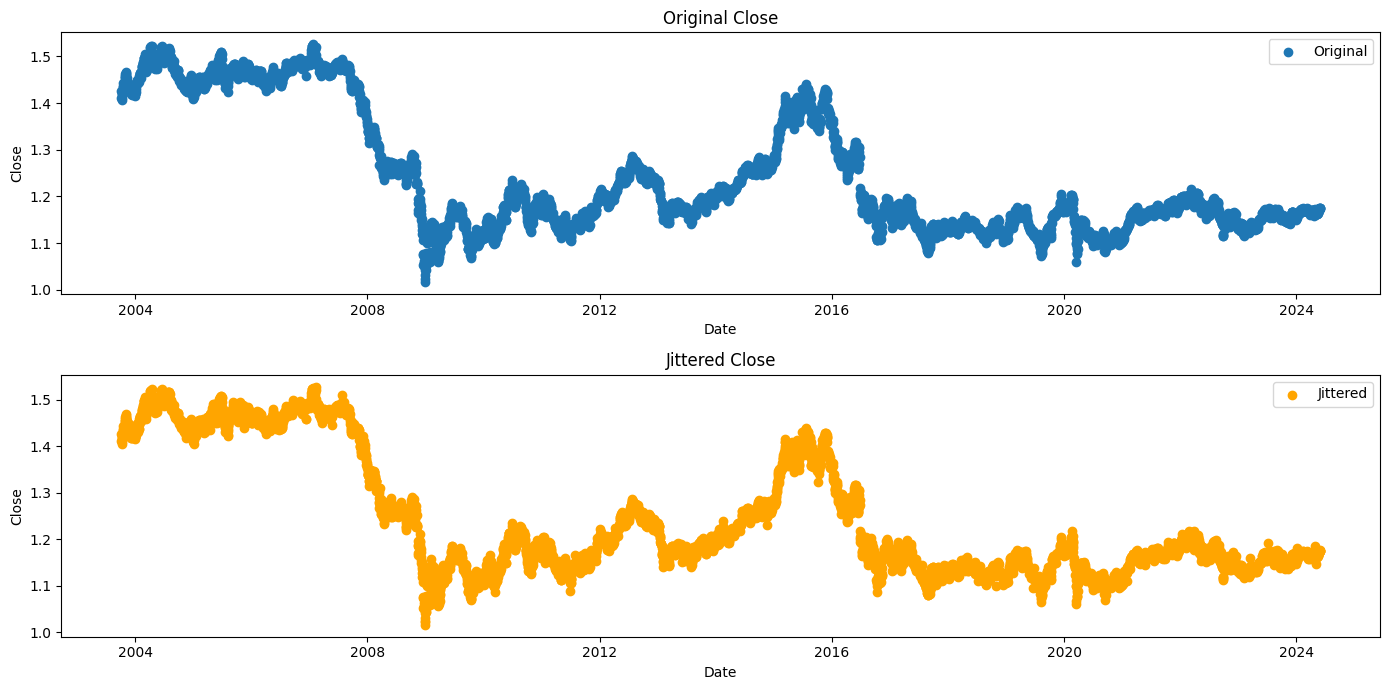

In [43]:
# Plot original and jittered data for comparison using the close column
def plot_comparison(df_original, df_jittered, column_name):
    """
    Function to visually compare the original dataset  and jittered version of the same dataset to show the distribution of the data sets

    Parameters:
    df_original: The original dataset containing a 'Date' column and the specified column of interest.
    df_jittered: The jittered or modified dataset, with the same structure as df_original, including a 'Date' column and the specified column of interest.
    column_name (str): The name of the column to be compared between the original and jittered datasets(Close)

    Returns:
    None: Generates and displays a visual comparison of the close column between the original and jittered datasets using scattered plot.
    """


    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.scatter(df_original['Date'], df_original[column_name], label='Original')
    plt.title(f'Original {column_name}')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.scatter(df_jittered['Date'], df_jittered[column_name], label='Jittered', color='orange')
    plt.title(f'Jittered {column_name}')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Ensure the 'Date' column in both the original and jittered datasets is in datetime format
cleaned_stock_data['Date'] = pd.to_datetime(cleaned_stock_data['Date'])
augmented_data['Date'] = pd.to_datetime(augmented_data['Date'])


plot_comparison(cleaned_stock_data, augmented_data, 'Close')


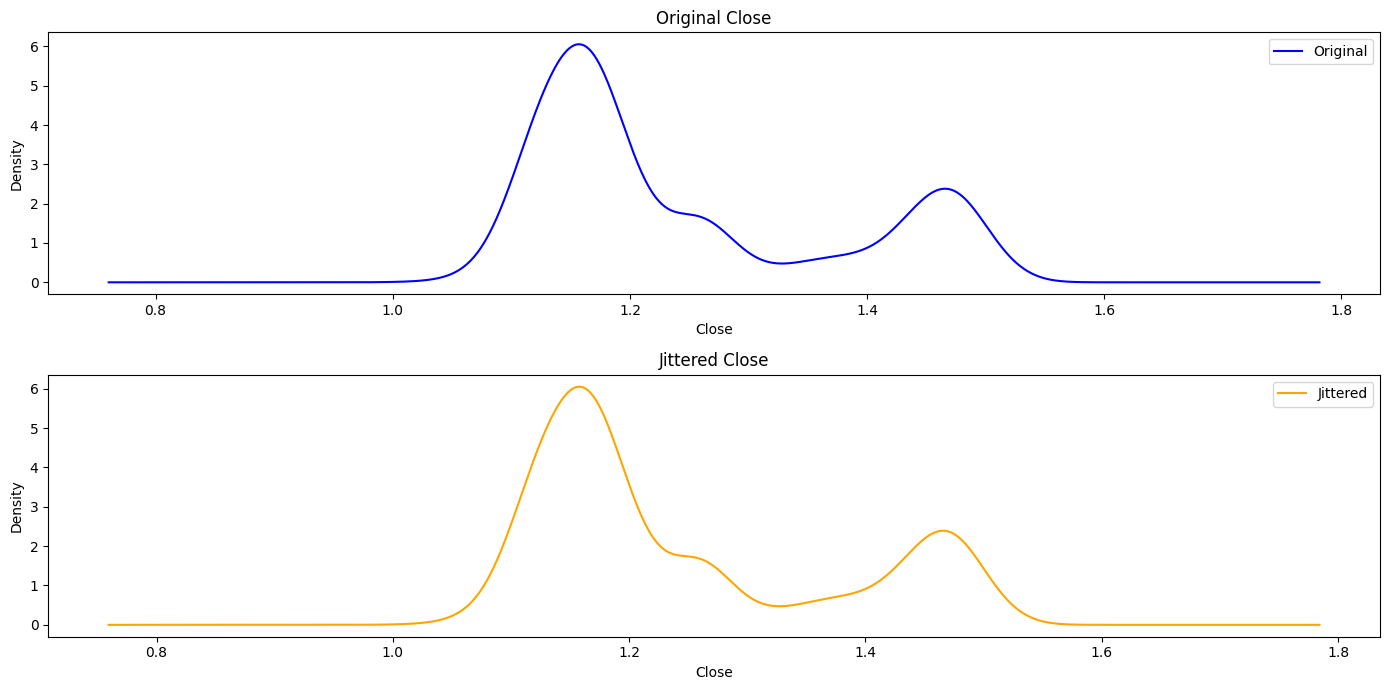

In [44]:
# Function to plot density comparison between the original and jittered datasets

def plot_density(df_original, df_jittered, column_name):
    """
    Function to plot the density comparison of a specified column between the original
    and jittered datasets. This helps in visualizing the distribution of the data.

    Parameters:
    df_original (pandas.DataFrame): The original dataset containing the specified column of interest.
    df_jittered (pandas.DataFrame): The jittered dataset containing the same specified column of interest.
    column_name (str): The name of the column to be compared between the original and jittered datasets.

    Returns:
    None: Generates and displays density plots for the specified column from both datasets.
    """

    plt.figure(figsize=(14, 7))

    # Density plot for original data
    plt.subplot(2, 1, 1)
    df_original[column_name].plot(kind='density', label='Original', color='blue')
    plt.title(f'Original {column_name}')
    plt.xlabel(column_name)
    plt.legend()

    # Density plot for jittered data
    plt.subplot(2, 1, 2)
    df_jittered[column_name].plot(kind='density', label='Jittered', color='orange')
    plt.title(f'Jittered {column_name}')
    plt.xlabel(column_name)
    plt.legend()

    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()

# Example for the 'Close' column
plot_density(cleaned_stock_data, augmented_data, 'Close')


Modelling

In [45]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

DATA PREPARATION FOR MODELLING

The model will be using the close price as the target variable because it reflects the final price at which the asset was traded at the end of the trading day. It is often seen as the most representative of the asset's value for that day because it incorporates all the market activity and sentiment up until the market close.

In [46]:
# Making a copy of the original cleaned_stock_data for version control
stock_df_copy = cleaned_stock_data.copy()

# Extract date column and reset index
dates = stock_df_copy['Date'].reset_index(drop=True)

# Separate features and target
# Drop the Date column for feature selection
numeric_df = stock_df_copy.drop(columns=['Date'])

 # Features are all columns except 'Close'
X_df = numeric_df.drop(columns=['Close'])

# Target is the 'Close' column
y_df = numeric_df[['Close']]

# Split the data into train, validation, and test sets
train_size = int(len(X_df) * 0.7)
val_size = int(len(X_df) * 0.15)
test_size = len(X_df) - train_size - val_size

X_train = X_df[:train_size]
X_val = X_df[train_size:train_size + val_size]
X_test = X_df[train_size + val_size:]

y_train = y_df[:train_size]
y_val = y_df[train_size:train_size + val_size]
y_test = y_df[train_size + val_size:]

# Split the dates accordingly
train_dates = dates[:train_size]
val_dates = dates[train_size:train_size + val_size]
test_dates = dates[train_size + val_size:]


print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")



Training set: (3751, 12), (3751, 1)
Validation set: (804, 12), (804, 1)
Test set: (805, 12), (805, 1)


Normalization, feature scaling and sequence creation

In [62]:
# Normalize the data separately
scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaled_X_train = scaler_X.fit_transform(X_train)
scaled_X_val = scaler_X.transform(X_val)
scaled_X_test = scaler_X.transform(X_test)

scaled_y_train = scaler_y.fit_transform(y_train)
scaled_y_val = scaler_y.transform(y_val)
scaled_y_test = scaler_y.transform(y_test)

# Convert to DataFrame for easier manipulation
scaled_X_train_df = pd.DataFrame(scaled_X_train, columns=X_df.columns)
scaled_X_val_df = pd.DataFrame(scaled_X_val, columns=X_df.columns)
scaled_X_test_df = pd.DataFrame(scaled_X_test, columns=X_df.columns)

scaled_y_train_df = pd.DataFrame(scaled_y_train, columns=['Close'])
scaled_y_val_df = pd.DataFrame(scaled_y_val, columns=['Close'])
scaled_y_test_df = pd.DataFrame(scaled_y_test, columns=['Close'])

# Function to create sequences
def create_sequences(data_X, data_y, sequence_length):
    """
    Function to create sequences from the dataset for time series forecasting.

    Parameters:
    data_X (pandas.DataFrame): The dataset containing the feature columns.
    data_y (pandas.DataFrame): The dataset containing the target column.
    sequence_length (int): The length of the sequences to be created.

    Returns:
    tuple: A tuple containing two numpy arrays:
        - sequences (numpy.ndarray): The array of sequences created from the feature dataset.
        - labels (numpy.ndarray): The array of labels corresponding to the sequences.
    """
    sequences = []
    labels = []
    for i in range(len(data_X) - sequence_length):
        sequence = data_X.iloc[i:i + sequence_length].values
        label = data_y.iloc[i + sequence_length].values
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define the sequence length
sequence_length = 50

# Create sequences for each set
X_train_seq, y_train_seq = create_sequences(scaled_X_train_df, scaled_y_train_df, sequence_length)
X_val_seq, y_val_seq = create_sequences(scaled_X_val_df, scaled_y_val_df, sequence_length)
X_test_seq, y_test_seq = create_sequences(scaled_X_test_df, scaled_y_test_df, sequence_length)

# Adjust dates for the sequence length
train_dates = train_dates[sequence_length:]
val_dates = val_dates[sequence_length:]
test_dates = test_dates[sequence_length:]

# Reshape for GRU Model(3 dimension)
X_train_gru = X_train_seq
X_val_gru = X_val_seq
X_test_gru = X_test_seq

print(f"GRU Training set: {X_train_gru.shape}, {y_train_seq.shape}")
print(f"GRU Validation set: {X_val_gru.shape}, {y_val_seq.shape}")
print(f"GRU Test set: {X_test_gru.shape}, {y_test_seq.shape}")
print()

# Reshape for XGBoost and Gaussian Process (2 Dimension)
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)
X_test_flat = X_test_seq.reshape(X_test_seq.shape[0], -1)

print(f"XGBoost/Gaussian Process Training set: {X_train_flat.shape}, {y_train_seq.shape}")
print(f"XGBoost/Gaussian Process Validation set: {X_val_flat.shape}, {y_val_seq.shape}")
print(f"XGBoost/Gaussian Process Test set: {X_test_flat.shape}, {y_test_seq.shape}")

GRU Training set: (3701, 50, 12), (3701, 1)
GRU Validation set: (754, 50, 12), (754, 1)
GRU Test set: (755, 50, 12), (755, 1)

XGBoost/Gaussian Process Training set: (3701, 600), (3701, 1)
XGBoost/Gaussian Process Validation set: (754, 600), (754, 1)
XGBoost/Gaussian Process Test set: (755, 600), (755, 1)


In [65]:
# Save the scalers
#save scaler X
dump(scaler_X, 'scaler_X.bin')

#save scaler X
dump(scaler_y, 'scaler_y.bin')

['scaler_y.bin']

GRU MODEL

In [48]:
def build_and_train_gru_model(X_train_gru, y_train_seq, X_val_gru, y_val_seq, input_shape):
    """
    Build and train a GRU model.

    Parameters:
    X_train_gru (np.ndarray): Training data for features.
    y_train_seq (np.ndarray): Training data for target variable.
    X_val_gru (np.ndarray): Validation data for features.
    y_val_seq (np.ndarray): Validation data for target variable.
    input_shape (tuple): Shape of the input data.

    Returns:
    model (Sequential): Trained GRU model.
    history (History): Training history of the model.
    """

    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_gru, y_train_seq, epochs=100, batch_size=32, validation_data=(X_val_gru, y_val_seq), callbacks=[early_stopping])

    return model, history

def predict_with_gru(model, X_test_gru, scaler_y, y_test_seq, scaled_X_test_df):
    """
    Make predictions using the trained GRU model and inverse transform the results.

    Parameters:
    model (Sequential): Trained GRU model.
    X_test_gru (np.ndarray): Test data for features.
    scaler_y (MinMaxScaler): Scaler used for target variable.
    y_test_seq (np.ndarray): Test data for target variable.
    scaled_X_test_df (pd.DataFrame): Scaled test data for features.

    Returns:
    y_test_actual (np.ndarray): Actual values of the target variable.
    y_pred_actual (np.ndarray): Predicted values of the target variable.
    """
    y_pred = model.predict(X_test_gru)
    y_test = y_test_seq.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)

    inverse_transform_data_test = np.hstack((np.zeros((y_test_seq.shape[0], scaled_X_test_df.shape[1] - 1)), y_test))
    inverse_transform_data_pred = np.hstack((np.zeros((y_pred.shape[0], scaled_X_test_df.shape[1] - 1)), y_pred))

    y_test_actual = scaler_y.inverse_transform(inverse_transform_data_test)[:, -1]
    y_pred_actual = scaler_y.inverse_transform(inverse_transform_data_pred)[:, -1]
    return y_test_actual, y_pred_actual


# Train the GRU model
gru_model, gru_history = build_and_train_gru_model(X_train_gru, y_train_seq, X_val_gru, y_val_seq, (X_train_gru.shape[1], X_train_gru.shape[2]))


# Make predictions with the GRU model
y_test_actual_gru, y_pred_actual_gru = predict_with_gru(gru_model, X_test_gru, scaler_y, y_test_seq, scaled_X_test_df)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50, 50)              │           9,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,951 (97.46 KB)

 Trainable params: 24,951 (97.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 0.1235 - val_loss: 0.0038
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0244 - val_loss: 0.0083
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0192 - val_loss: 0.0102
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0155 - val_loss: 0.0021
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0152 - val_loss: 0.0019
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0135 - val_loss: 0.0064
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0126 - val_loss: 0.0026
Epoch 8/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.0131 - val_loss: 0.0048
Epoch 9/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0115 - val_loss: 0.0087
Epoch 10/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 0.0116 - val_loss: 0.0066
Epoch 11/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 0.0109 - val_loss: 0.0018
Epoch 12/100
116/116 ━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


**Evaluate GRU model accuracy using R² score.**

In [49]:
# Make predictions on the training set
gru_train_predictions = gru_model.predict(X_train_gru)
y_train_seq_inverse_gru = scaler_y.inverse_transform(y_train_seq)
gru_train_predictions = scaler_y.inverse_transform(gru_train_predictions)

# Calculate R² score for the training set
r2_gru_train = r2_score(y_train_seq_inverse_gru, gru_train_predictions)
print(f'R² score for GRU on training set: {r2_gru_train:.2f}')

# Make predictions on the test set
gru_test_predictions = gru_model.predict(X_test_gru)
y_test_seq_inverse_gru = scaler_y.inverse_transform(y_test_seq)
gru_test_predictions = scaler_y.inverse_transform(gru_test_predictions)

# Calculate R² score for the test set
r2_gru_test = r2_score(y_test_seq_inverse_gru, gru_test_predictions)
print(f'R² score for GRU on test set: {r2_gru_test:.2f}')

116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
R² score for GRU on training set: 1.00
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
R² score for GRU on test set: 0.97


Building the GRU model for the augmented data

In [50]:
""" Making a copy of the augmented cleaned_stock_data for version control
augmented_df_copy = augmented_data.copy()

# Extract date column and reset index
aug_dates = augmented_df_copy['Date'].reset_index(drop=True)

# Separate features and target

# Drop the Date column for feature selection
aug_numeric_df = augmented_df_copy.drop(columns=['Date'])

# Features are all columns except 'Close'
aug_X_df = aug_numeric_df.drop(columns=['Close'])

# Target is the 'Close' column
aug_y_df = aug_numeric_df[['Close']]

# Split the data into train, validation, and test sets
train_size = int(len(aug_X_df) * 0.7)
val_size = int(len(aug_X_df) * 0.15)
test_size = len(aug_X_df) - train_size - val_size

aug_X_train = aug_X_df[:train_size]
aug_X_val = aug_X_df[train_size:train_size + val_size]
aug_X_test = aug_X_df[train_size + val_size:]

aug_y_train = aug_y_df[:train_size]
aug_y_val = aug_y_df[train_size:train_size + val_size]
aug_y_test = aug_y_df[train_size + val_size:]

# Split the dates accordingly
aug_train_dates = aug_dates[:train_size]
aug_val_dates = aug_dates[train_size:train_size + val_size]
aug_test_dates = aug_dates[train_size + val_size:]

print(f"Training set: {aug_X_train.shape}, {aug_y_train.shape}")
print(f"Validation set: {aug_X_val.shape}, {aug_y_val.shape}")
print(f"Test set: {aug_X_test.shape}, {aug_y_test.shape}")

# Normalize the data separately
aug_scaler_X = StandardScaler()
aug_scaler_y = StandardScaler()

aug_scaled_X_train = aug_scaler_X.fit_transform(aug_X_train)
aug_scaled_X_val = aug_scaler_X.transform(aug_X_val)
aug_scaled_X_test = aug_scaler_X.transform(aug_X_test)

aug_scaled_y_train = aug_scaler_y.fit_transform(aug_y_train)
aug_scaled_y_val = aug_scaler_y.transform(aug_y_val)
aug_scaled_y_test = aug_scaler_y.fit_transform(aug_y_test)

# Convert to DataFrame for easier manipulation
aug_scaled_X_train_df = pd.DataFrame(aug_scaled_X_train, columns=aug_X_df.columns)
aug_scaled_X_val_df = pd.DataFrame(aug_scaled_X_val, columns=aug_X_df.columns)
aug_scaled_X_test_df = pd.DataFrame(aug_scaled_X_test, columns=aug_X_df.columns)

aug_scaled_y_train_df = pd.DataFrame(aug_scaled_y_train, columns=['Close'])
aug_scaled_y_val_df = pd.DataFrame(aug_scaled_y_val, columns=['Close'])
aug_scaled_y_test_df = pd.DataFrame(aug_scaled_y_test, columns=['Close'])

# Function to create sequences
def create_sequences(data_X, data_y, sequence_length):

    Function to create sequences from the dataset for time series forecasting.

    Parameters:
    data_X (pandas.DataFrame): The dataset containing the feature columns.
    data_y (pandas.DataFrame): The dataset containing the target column.
    sequence_length (int): The length of the sequences to be created.

    Returns:
    tuple: A tuple containing two numpy arrays:
        - sequences (numpy.ndarray): The array of sequences created from the feature dataset.
        - labels (numpy.ndarray): The array of labels corresponding to the sequences.

    sequences = []
    labels = []
    for i in range(len(data_X) - sequence_length):
        sequence = data_X.iloc[i:i + sequence_length].values
        label = data_y.iloc[i + sequence_length].values
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define the sequence length
sequence_length = 50

# Create sequences for each set
aug_X_train_seq, aug_y_train_seq = create_sequences(aug_scaled_X_train_df, aug_scaled_y_train_df, sequence_length)
aug_X_val_seq, aug_y_val_seq = create_sequences(aug_scaled_X_val_df, aug_scaled_y_val_df, sequence_length)
aug_X_test_seq, aug_y_test_seq = create_sequences(aug_scaled_X_test_df, aug_scaled_y_test_df, sequence_length)

# Adjust dates for the sequence length
aug_train_dates = aug_train_dates[sequence_length:]
aug_val_dates = aug_val_dates[sequence_length:]
aug_test_dates = aug_test_dates[sequence_length:]

# Reshape for GRU Model
aug_X_train_gru = aug_X_train_seq
aug_X_val_gru = aug_X_val_seq
aug_X_test_gru = aug_X_test_seq

print(f"GRU Training set: {aug_X_train_gru.shape}, {aug_y_train_seq.shape}")
print(f"GRU Validation set: {aug_X_val_gru.shape}, {aug_y_val_seq.shape}")
print(f"GRU Test set: {aug_X_test_gru.shape}, {aug_y_test_seq.shape}")
print()

# Reshape for XGBoost and Gaussian Process
aug_X_train_flat = aug_X_train_seq.reshape(aug_X_train_seq.shape[0], -1)
aug_X_val_flat = aug_X_val_seq.reshape(aug_X_val_seq.shape[0], -1)
aug_X_test_flat = aug_X_test_seq.reshape(aug_X_test_seq.shape[0], -1)

print(f"XGBoost/Gaussian Process Training set: {aug_X_train_flat.shape}, {aug_y_train_seq.shape}")
print(f"XGBoost/Gaussian Process Validation set: {aug_X_val_flat.shape}, {aug_y_val_seq.shape}")
print(f"XGBoost/Gaussian Process Test set: {aug_X_test_flat.shape}, {aug_y_test_seq.shape}")

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(aug_X_train_gru.shape[1], aug_X_train_gru.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model with a specified learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(aug_X_train_gru, aug_y_train_seq, epochs=100, batch_size=32, validation_data=(aug_X_val_gru, aug_y_val_seq), callbacks=[early_stopping])

# Save the model
model.save('augmented_gru_model.h5')

# Make predictions
y_pred = model.predict(aug_X_test_gru)

# Inverse transform predictions for evaluation
aug_y_test = aug_y_test_seq.reshape(-1, 1)
aug_y_pred = y_pred.reshape(-1, 1)

# Adding back the columns removed before normalization
inverse_transform_data_test = np.hstack((np.zeros((aug_y_test_seq.shape[0], aug_scaled_X_test_df.shape[1]-1)), aug_y_test))
inverse_transform_data_pred = np.hstack((np.zeros((aug_y_pred.shape[0], aug_scaled_X_test_df.shape[1]-1)), aug_y_pred))

# Inverse transform to get actual values
aug_y_test_actual = aug_scaler_y.inverse_transform(inverse_transform_data_test)[:, -1]
aug_y_pred_actual = aug_scaler_y.inverse_transform(inverse_transform_data_pred)[:, -1]

# Using R² to evaluate prediction
r2_train_data = r2_score(aug_y_train_seq, model.predict(aug_X_train_gru).reshape(-1, 1))
r2_gru = r2_score(aug_y_test_actual, aug_y_pred_actual)

print(f'R² Score for Training_data_set: {r2_train_data:.2f}')
print(f'R² Score for Prediction : {r2_gru:.2f}')

# Function to format x-axis for dates
def format_date_axis(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plotting the predictions
plt.figure(figsize=(14, 5))
plt.plot(aug_test_dates, aug_y_test_actual, label='Actual Price')
plt.plot(aug_test_dates, aug_y_pred_actual, label='Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
format_date_axis(plt.gca())

# Plotting the residuals
aug_residuals = aug_y_test_actual - aug_y_pred_actual
plt.figure(figsize=(14, 5))
plt.plot(aug_test_dates, aug_residuals, label='Residuals', color='green')
plt.title('Residuals of Predictions with GRU Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
format_date_axis(plt.gca())

plt.show()
"""

' Making a copy of the augmented cleaned_stock_data for version control\naugmented_df_copy = augmented_data.copy()\n\n# Extract date column and reset index\naug_dates = augmented_df_copy[\'Date\'].reset_index(drop=True)\n\n# Separate features and target\n\n# Drop the Date column for feature selection\naug_numeric_df = augmented_df_copy.drop(columns=[\'Date\'])\n\n# Features are all columns except \'Close\'\naug_X_df = aug_numeric_df.drop(columns=[\'Close\'])\n\n# Target is the \'Close\' column\naug_y_df = aug_numeric_df[[\'Close\']]\n\n# Split the data into train, validation, and test sets\ntrain_size = int(len(aug_X_df) * 0.7)\nval_size = int(len(aug_X_df) * 0.15)\ntest_size = len(aug_X_df) - train_size - val_size\n\naug_X_train = aug_X_df[:train_size]\naug_X_val = aug_X_df[train_size:train_size + val_size]\naug_X_test = aug_X_df[train_size + val_size:]\n\naug_y_train = aug_y_df[:train_size]\naug_y_val = aug_y_df[train_size:train_size + val_size]\naug_y_test = aug_y_df[train_size + va

XGBOOST MODEL

In [51]:
def build_and_train_xgb_model(X_train_flat, y_train_seq, X_val_flat, y_val_seq):
    """
    Build and train an XGBoost model.

    Parameters:
    X_train_flat (np.ndarray): Flattened training data for features.
    y_train_seq (np.ndarray): Training data for target variable.
    X_val_flat (np.ndarray): Flattened validation data for features.
    y_val_seq (np.ndarray): Validation data for target variable.

    Returns:
    xgb_model (XGBRegressor): Trained XGBoost model.
    """
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
    xgb_model.fit(X_train_flat, y_train_seq.ravel(), eval_set=[(X_val_flat, y_val_seq.ravel())], early_stopping_rounds=10, verbose=False)

    return xgb_model

def predict_with_xgb(xgb_model, X_test_flat, scaler_y, y_test_seq, scaled_X_test_df):
    """
    Make predictions using the trained XGBoost model and inverse transform the results.

    Parameters:
    xgb_model (XGBRegressor): Trained XGBoost model.
    X_test_flat (np.ndarray): Flattened test data for features.
    scaler_y (MinMaxScaler): Scaler used for target variable.
    y_test_seq (np.ndarray): Test data for target variable.
    scaled_X_test_df (pd.DataFrame): Scaled test data for features.

    Returns:
    y_test_actual (np.ndarray): Actual values of the target variable.
    y_pred_actual_xgb_test (np.ndarray): Predicted values of the target variable.
    """
    y_pred_xgb_test = xgb_model.predict(X_test_flat)
    y_pred_xgb_test = y_pred_xgb_test.reshape(-1, 1)

    inverse_transform_data_test = np.hstack((np.zeros((y_test_seq.shape[0], scaled_X_test_df.shape[1] - 1)), y_test_seq.reshape(-1, 1)))
    inverse_transform_data_pred_xgb_test = np.hstack((np.zeros((y_pred_xgb_test.shape[0], scaled_X_test_df.shape[1] - 1)), y_pred_xgb_test))

    y_test_actual = scaler_y.inverse_transform(inverse_transform_data_test)[:, -1]
    y_pred_actual_xgb_test = scaler_y.inverse_transform(inverse_transform_data_pred_xgb_test)[:, -1]
    return y_test_actual, y_pred_actual_xgb_test


# Train the GRU model
xgb_model = build_and_train_xgb_model(X_train_flat, y_train_seq, X_val_flat, y_val_seq)

# Make predictions with the GRU model
y_test_actual_xgb, y_pred_actual_xgb = predict_with_xgb(xgb_model, X_test_flat, scaler_y, y_test_seq, scaled_X_test_df)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


**# Evaluate Xgboost model accuracy using R² score**

In [53]:
# Make predictions on the training set
xgb_train_predictions = xgb_model.predict(X_train_flat)
y_train_seq_inverse_xgb = scaler_y.inverse_transform(y_train_seq)
xgb_train_predictions = scaler_y.inverse_transform(xgb_train_predictions.reshape(-1, 1))

# Calculate R² score for the training set
r2_xgb_train = r2_score(y_train_seq_inverse_xgb, xgb_train_predictions)
print(f'R² score for XGBoost on training set: {r2_xgb_train:.2f}')

# Make predictions on the test set
xgb_test_predictions = xgb_model.predict(X_test_flat)
y_test_seq_inverse_xgb = scaler_y.inverse_transform(y_test_seq)
xgb_test_predictions = scaler_y.inverse_transform(xgb_test_predictions.reshape(-1, 1))

# Calculate R² score for the test set
r2_xgb_test = r2_score(y_test_seq_inverse_xgb, xgb_test_predictions)
print(f'R² score for XGBoost on test set: {r2_xgb_test:.2f}')

R² score for XGBoost on training set: 1.00
R² score for XGBoost on test set: 0.98


GUASSIAN PROCESS REGRESSOR MODEL

In [54]:
def build_and_train_gpr_model(X_train_flat, y_train_seq):
    """
    Build and train a Gaussian Process Regressor model.

    Parameters:
    X_train_flat (np.ndarray): Flattened training data for features.
    y_train_seq (np.ndarray): Training data for target variable.

    Returns:
    gpr_model (GaussianProcessRegressor): Trained Gaussian Process Regressor model.
    """
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
    gpr_model.fit(X_train_flat, y_train_seq.ravel())

    return gpr_model

def predict_with_gpr(gpr_model, X_test_flat, scaler_y, y_test_seq, scaled_X_test_df):
    """
    Make predictions using the trained Gaussian Process Regressor model and inverse transform the results.

    Parameters:
    gpr_model (GaussianProcessRegressor): Trained Gaussian Process Regressor model.
    X_test_flat (np.ndarray): Flattened test data for features.
    scaler_y (MinMaxScaler): Scaler used for target variable.
    y_test_seq (np.ndarray): Test data for target variable.
    scaled_X_test_df (pd.DataFrame): Scaled test data for features.

    Returns:
    y_test_actual (np.ndarray): Actual values of the target variable.
    y_pred_actual_gpr_test (np.ndarray): Predicted values of the target variable.
    sigma_gpr_test (np.ndarray): Standard deviation of the predictions.
    """
    y_pred_gpr_test, sigma_gpr_test = gpr_model.predict(X_test_flat, return_std=True)
    y_pred_gpr_test = y_pred_gpr_test.reshape(-1, 1)

    inverse_transform_data_test = np.hstack((np.zeros((y_test_seq.shape[0], scaled_X_test_df.shape[1] - 1)), y_test_seq.reshape(-1, 1)))
    inverse_transform_data_pred_gpr_test = np.hstack((np.zeros((y_pred_gpr_test.shape[0], scaled_X_test_df.shape[1] - 1)), y_pred_gpr_test))

    y_test_actual = scaler_y.inverse_transform(inverse_transform_data_test)[:, -1]
    y_pred_actual_gpr_test = scaler_y.inverse_transform(inverse_transform_data_pred_gpr_test)[:, -1]
    return y_test_actual, y_pred_actual_gpr_test, sigma_gpr_test


# Train the GRU model
gpr_model = build_and_train_gpr_model(X_train_flat, y_train_seq)

# Make predictions with the GRU model
y_test_actual_gpr, y_pred_actual_gpr, sigma_gpr_test = predict_with_gpr(gpr_model, X_test_flat, scaler_y, y_test_seq, scaled_X_test_df)


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


**Evaluate Guassian Process Regressor model uisng R² score**

In [55]:
# Make predictions on the training set
gpr_train_predictions, _ = gpr_model.predict(X_train_flat, return_std=True)
y_train_seq_inverse_gpr = scaler_y.inverse_transform(y_train_seq)
gpr_train_predictions = scaler_y.inverse_transform(gpr_train_predictions.reshape(-1, 1))

# Calculate R² score for the training set
r2_gpr_train = r2_score(y_train_seq_inverse_gpr, gpr_train_predictions)
print(f'R² score for GPR on training set: {r2_gpr_train:.2f}')

# Make predictions on the test set
gpr_test_predictions, _ = gpr_model.predict(X_test_flat, return_std=True)
y_test_seq_inverse_gpr = scaler_y.inverse_transform(y_test_seq)
gpr_test_predictions = scaler_y.inverse_transform(gpr_test_predictions.reshape(-1, 1))

# Calculate R² score for the test set
r2_gpr_test = r2_score(y_test_seq_inverse_gpr, gpr_test_predictions)
print(f'R² score for GPR on test set: {r2_gpr_test:.2f}')

R² score for GPR on training set: 1.00
R² score for GPR on test set: 0.97


Hyper-parameter tunning for Guassian Process Regressor.

In [ ]:
# Use the flattened sequences for Guassian Process Regressor model
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define the kernel for the Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Train and evaluate Gaussian Process model
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Lists to store the training and validation losses
train_losses_gpr = []
val_losses_gpr = []

# Custom training loop to track losses
for i in range(1, 11):
    gpr_model.fit(X_train_flat, y_train)

    y_train_pred_gpr, _ = gpr_model.predict(X_train_flat, return_std=True)
    y_val_pred_gpr, _ = gpr_model.predict(X_val_flat, return_std=True)

    train_loss_gpr = mean_squared_error(y_train_seq, y_train_pred_gpr)
    val_loss_gpr = mean_squared_error(y_val_seq, y_val_pred_gpr)

    train_losses_gpr.append(train_loss_gpr)
    val_losses_gpr.append(val_loss_gpr)

    print(f'Iteration {i} - Train Loss: {train_loss_gpr:.4f}, Validation Loss: {val_loss_gpr:.4f}')

# Save the model
joblib.dump(gpr_model, 'gpr_model_hyperparmeter.joblib')

# Make predictions with Gaussian Process model
y_pred_gpr, sigma_gpr = gpr_model.predict(X_test_flat, return_std=True)
y_train_pred_gpr, _ = gpr_model.predict(X_train_flat, return_std=True)

# Inverse transform predictions for evaluation
y_test = y_test_seq.reshape(-1, 1)
y_pred_gpr = y_pred_gpr.reshape(-1, 1)
y_train_pred_gpr = y_train_pred_gpr.reshape(-1, 1)

# Adding back the columns removed before normalization
inverse_transform_data_train = np.hstack((np.zeros((y_train_seq.shape[0], scaled_df.shape[1] - 1)), y_train_seq.reshape(-1, 1)))
inverse_transform_data_test = np.hstack((np.zeros((y_test.shape[0], scaled_df.shape[1] - 1)), y_test))
inverse_transform_data_pred_gpr_train = np.hstack((np.zeros((y_train_pred_gpr.shape[0], scaled_df.shape[1] - 1)), y_train_pred_gpr))
inverse_transform_data_pred_gpr_test = np.hstack((np.zeros((y_pred_gpr.shape[0], scaled_df.shape[1] - 1)), y_pred_gpr))

# Inverse transform to get actual values
y_train_actual = scaler.inverse_transform(inverse_transform_data_train)[:, -1]
y_test_actual = scaler.inverse_transform(inverse_transform_data_test)[:, -1]
y_pred_actual_gpr_train = scaler.inverse_transform(inverse_transform_data_pred_gpr_train)[:, -1]
y_pred_actual_gpr_test = scaler.inverse_transform(inverse_transform_data_pred_gpr_test)[:, -1]

# Calculate R² score for the Gaussian Process model
r2_gpr_train = r2_score(y_train_actual, y_pred_actual_gpr_train)
r2_gpr = r2_score(y_test_actual, y_pred_actual_gpr_test)

print(f'R² Score for Gaussian Process Training data:{r2_gpr_train:.2f}')
print(f'R² Score for Gaussian Process Prediction: {r2_gpr_test:.2f}')

# Function to format x-axis for dates
def format_date_axis(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()

# Plotting the predictions
plt.figure(figsize=(14, 7))
plt.plot(dates_test_seq, y_test_actual, label='Actual', color='blue')
plt.plot(dates_test_seq, y_pred_actual_gpr_test, label='Predicted', color='red')
plt.fill_between(dates_test_seq, y_pred_actual_gpr_test.flatten() - 1.96 * sigma_gpr, y_pred_actual_gpr_test.flatten() + 1.96 * sigma_gpr, color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('Actual vs Predicted Close Prices (Gaussian Process)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
format_date_axis(plt.gca())
plt.show()

# Plotting the residuals for Gaussian Process model
residuals_gpr = y_test_actual - y_pred_actual_gpr_test
plt.figure(figsize=(14, 7))
plt.plot(dates_test_seq, residuals_gpr, label='Residuals', color='green')
plt.title('Residuals of Predictions (Gaussian Process)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
format_date_axis(plt.gca())
plt.show()


**Saving the trained models**

In [58]:
from tensorflow.keras.models import save_model

# Define file paths
gru_model_path = 'model_gru.keras'
xgb_model_path = 'model_xgb.json'
gpr_model_path = 'model_gpr.pkl'

# save the GRU model
save_model(gru_model, gru_model_path)
print(f"GRU model saved as '{gru_model_path}'")

# save the XGBoost model
xgb_model.save_model(xgb_model_path)
print(f"XGBoost model saved as '{xgb_model_path}'")

# save the GPR model
joblib.dump(gpr_model, gpr_model_path)
print(f"GPR model saved as '{gpr_model_path}'")

GRU model saved as 'model_gru.keras'
XGBoost model saved as 'model_xgb.json'
GPR model saved as 'model_gpr.pkl'


**Loading in Models**

In [59]:
# Load the saved models
def load_in_models():
    """
    Load the saved models from disk.

    Returns:
    tuple: A tuple containing the loaded GRU, XGBoost, and Random Forest models.
    """
    load_model_gru = load_in_models('model_gru.keras')
    load_model_xgb = xgb.Booster()
    load_model_xgb.load_in_models('model_xgb.json')
    load_model_gpr = load('model_gpr.pkl')
    return load_model_gru, load_model_xgb, load_model_rf

In [60]:
from tensorflow.keras.models import load_model

def load_models():
    """
    Load the saved models from disk.

    Returns:
    tuple: A tuple containing the loaded GRU, XGBoost, and Gaussian Process Regressor models.
    """
    # Load the GRU model
    model_gru = load_model('model_gru.keras')

    # Load the XGBoost model
    model_xgb = xgb.Booster()
    model_xgb.load_model('model_xgb.json')

    # Load the Gaussian Process Regressor model
    model_gpr = joblib.load('model_gpr.pkl')

    return model_gru, model_xgb, model_gpr

# Call the function to load models
model_gru, model_xgb, model_gpr = load_models()


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**MODEL EVALUATION**

In [66]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true (array-like): True target values.
    y_pred (array-like): Predicted target values.

    Returns:
    float: The MAPE value.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate and return evaluation metrics for the three models
def evaluate_model(y_true, y_pred, model_name):
    """
    Calculate and return evaluation metrics for a regression model.

    Parameters:
    y_true (array-like): True target values.
    y_pred (array-like): Predicted target values.
    model_name (str): The name of the model being evaluated.

    Returns:
    dict: A dictionary containing the evaluation metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    metrics = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

    return metrics


# Evaluate models
gru_metrics = evaluate_model(y_test_actual_gru, y_pred_actual_gru, "GRU")
xgb_metrics = evaluate_model(y_test_actual_xgb, y_pred_actual_xgb, "XGBoost")
gpr_metrics = evaluate_model(y_test_actual_gpr, y_pred_actual_gpr, "Gaussian Process")

# Combine all metrics into a DataFrame and display
all_metrics = pd.DataFrame([gru_metrics, xgb_metrics, gpr_metrics])
print(all_metrics)

              Model       MAE       MSE      RMSE        R²      MAPE
0               GRU  0.002614  0.000012  0.003534  0.965703  0.224753
1           XGBoost  0.002214  0.000009  0.003003  0.975231  0.190477
2  Gaussian Process  0.002598  0.000012  0.003507  0.966236  0.223413


Plotting Predictions and residuals for the models

Shape of test_dates: (705,)
Shape of y_test_actual_gru: (755,)
Shape of y_pred_actual_gru: (755,)
Shape of y_test_actual_xgb: (755,)
Shape of y_pred_actual_xgb: (755,)
Shape of y_test_actual_gpr: (755,)
Shape of y_pred_actual_gpr: (755,)


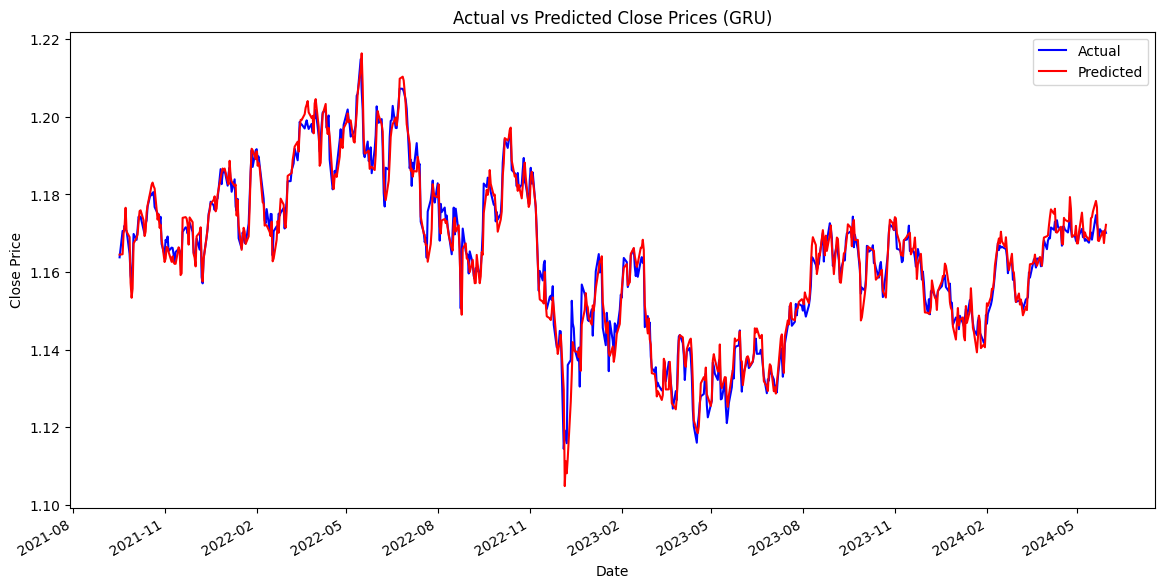

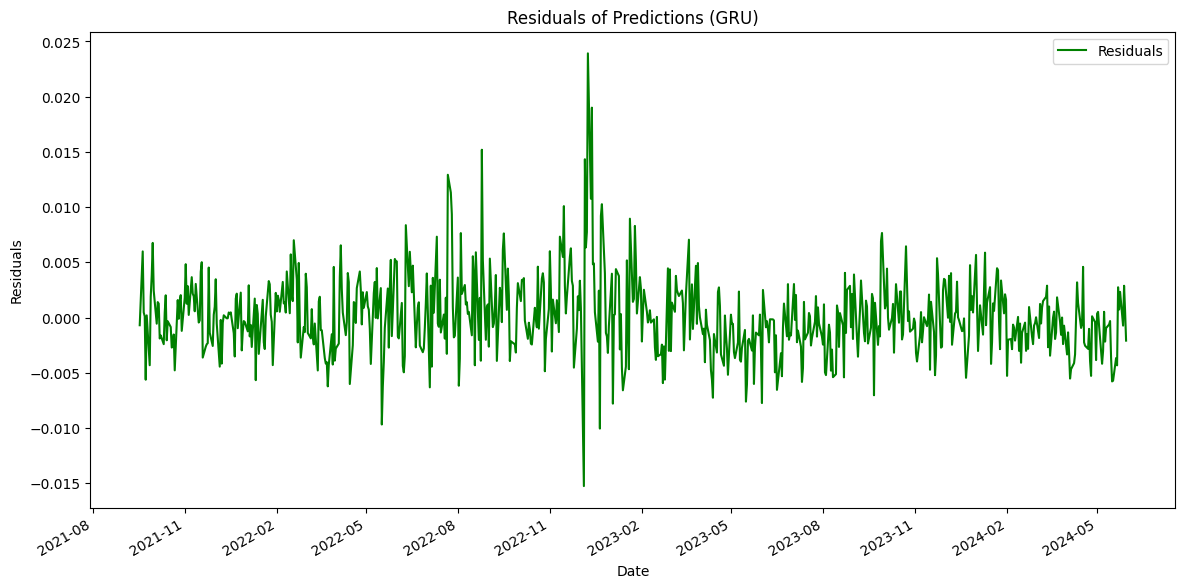

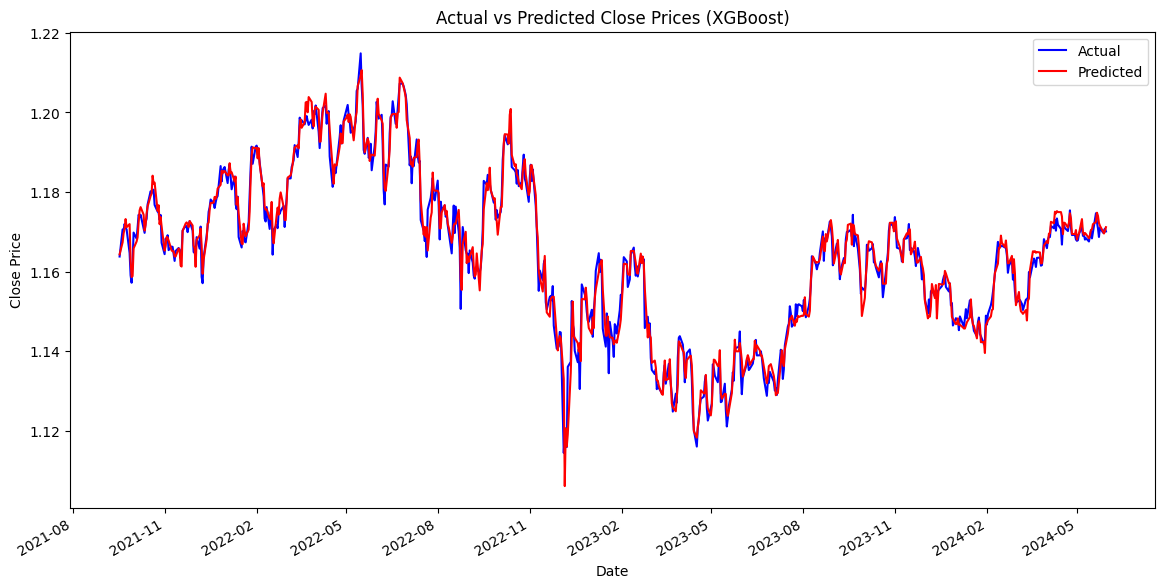

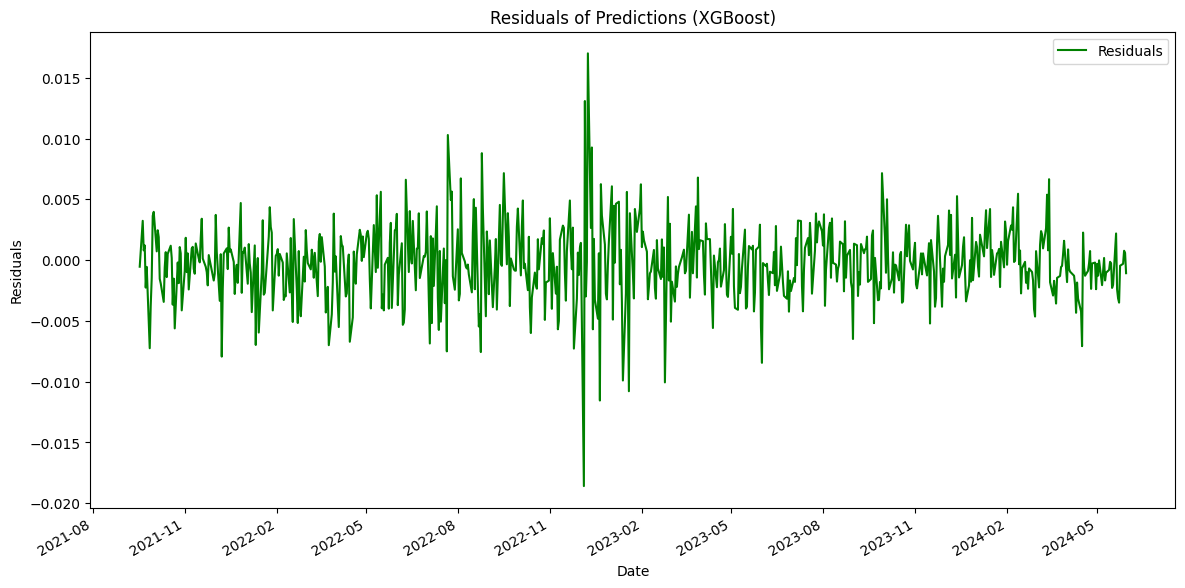

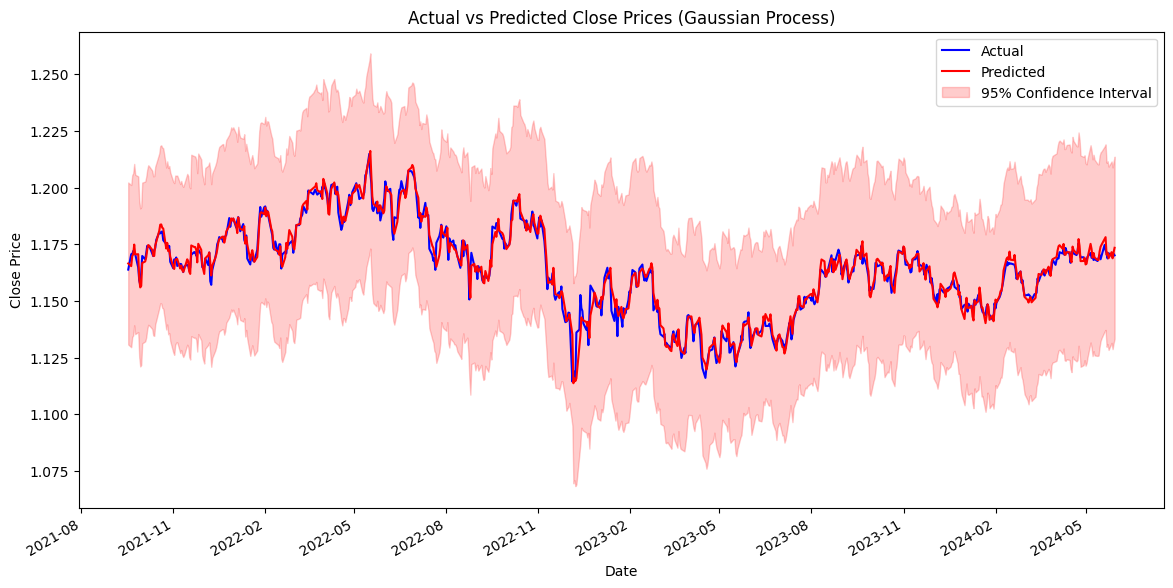

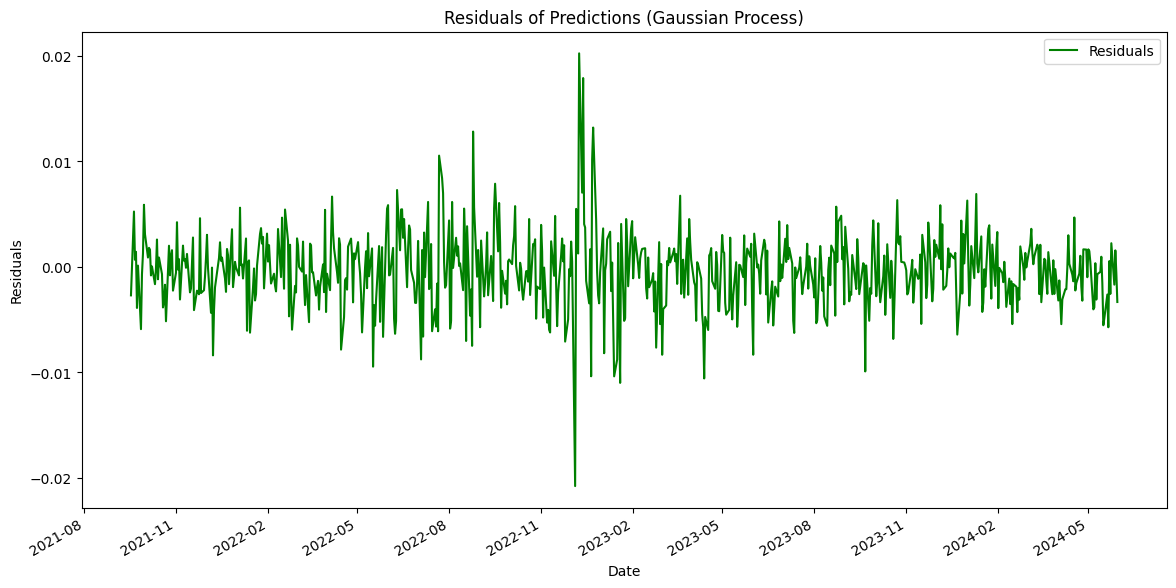

In [70]:
def format_date_axis(ax):
    """
    Format the x-axis to display dates in a readable format.

    Parameters:
    ax (matplotlib.axes.Axes): The axes object to format.
    """
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()

def plot_predictions(dates, y_test_actual, y_pred_actual, model_name):
    """
    Plot actual vs predicted close prices.

    Parameters:
    dates (pd.Series): Dates for the x-axis.
    y_test_actual (np.ndarray): Actual values of the target variable.
    y_pred_actual (np.ndarray): Predicted values of the target variable.
    model_name (str): Name of the model used for predictions.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_test_actual, label='Actual', color='blue')
    plt.plot(dates, y_pred_actual, label='Predicted', color='red')
    plt.title(f'Actual vs Predicted Close Prices ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    format_date_axis(plt.gca())
    plt.show()

def plot_residuals(dates, y_test_actual, y_pred_actual, model_name):
    """
    Plot residuals of predictions.

    Parameters:
    dates (pd.Series): Dates for the x-axis.
    y_test_actual (np.ndarray): Actual values of the target variable.
    y_pred_actual (np.ndarray): Predicted values of the target variable.
    model_name (str): Name of the model used for predictions.
    """
    residuals = y_test_actual - y_pred_actual
    plt.figure(figsize=(14, 7))
    plt.plot(dates, residuals, label='Residuals', color='green')
    plt.title(f'Residuals of Predictions ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend()
    format_date_axis(plt.gca())
    plt.show()

# Plotting GPR prediction separately because it includes confidence intervals
def plot_gpr_predictions(dates, y_test_actual, y_pred_actual, sigma_gpr_test):
    """
    Plot actual vs predicted close prices with 95% confidence interval for Gaussian Process.

    Parameters:
    dates (pd.Series): Dates for the x-axis.
    y_test_actual (np.ndarray): Actual values of the target variable.
    y_pred_actual (np.ndarray): Predicted values of the target variable.
    sigma_gpr_test (np.ndarray): Standard deviation of the predictions.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_test_actual, label='Actual', color='blue')
    plt.plot(dates, y_pred_actual, label='Predicted', color='red')
    plt.fill_between(dates, y_pred_actual.flatten() - 1.96 * sigma_gpr_test, y_pred_actual.flatten() + 1.96 * sigma_gpr_test, color='red', alpha=0.2, label='95% Confidence Interval')
    plt.title('Actual vs Predicted Close Prices (Gaussian Process)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    format_date_axis(plt.gca())
    plt.show()

# Print the shapes of the arrays to debug
print(f"Shape of test_dates: {test_dates.shape}")
print(f"Shape of y_test_actual_gru: {y_test_actual_gru.shape}")
print(f"Shape of y_pred_actual_gru: {y_pred_actual_gru.shape}")
print(f"Shape of y_test_actual_xgb: {y_test_actual_xgb.shape}")
print(f"Shape of y_pred_actual_xgb: {y_pred_actual_xgb.shape}")
print(f"Shape of y_test_actual_gpr: {y_test_actual_gpr.shape}")
print(f"Shape of y_pred_actual_gpr: {y_pred_actual_gpr.shape}")

# Ensure the lengths match
min_len = min(len(test_dates), len(y_test_actual_gru), len(y_pred_actual_gru))

# Slice the arrays to the minimum length
test_dates = test_dates[:min_len]
y_test_actual_gru = y_test_actual_gru[:min_len]
y_pred_actual_gru = y_pred_actual_gru[:min_len]
y_test_actual_xgb = y_test_actual_xgb[:min_len]
y_pred_actual_xgb = y_pred_actual_xgb[:min_len]
y_test_actual_gpr = y_test_actual_gpr[:min_len]
y_pred_actual_gpr = y_pred_actual_gpr[:min_len]
sigma_gpr_test = sigma_gpr_test[:min_len]

# Plot results
plot_predictions(test_dates, y_test_actual_gru, y_pred_actual_gru, "GRU")
plot_residuals(test_dates, y_test_actual_gru, y_pred_actual_gru, "GRU")

plot_predictions(test_dates, y_test_actual_xgb, y_pred_actual_xgb, "XGBoost")
plot_residuals(test_dates, y_test_actual_xgb, y_pred_actual_xgb, "XGBoost")

plot_gpr_predictions(test_dates, y_test_actual_gpr, y_pred_actual_gpr, sigma_gpr_test)
plot_residuals(test_dates, y_test_actual_gpr, y_pred_actual_gpr, "Gaussian Process")


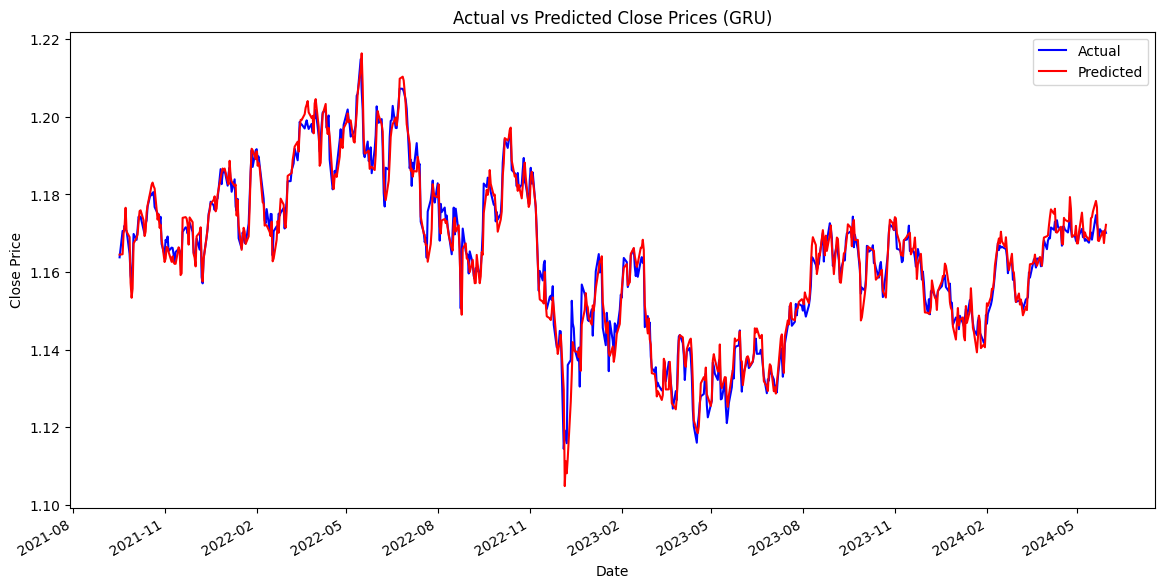

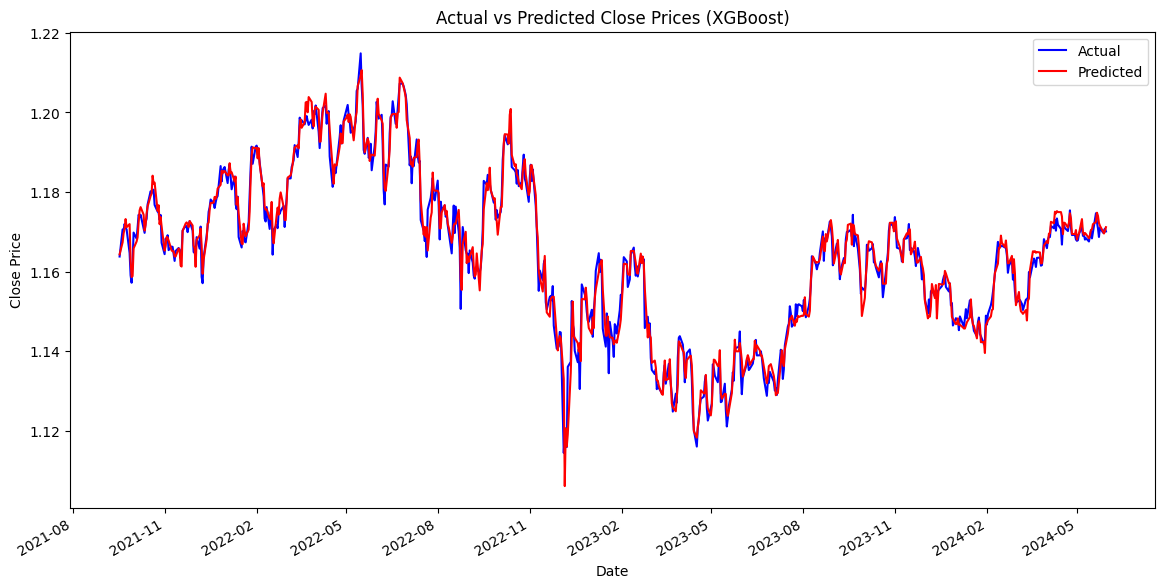

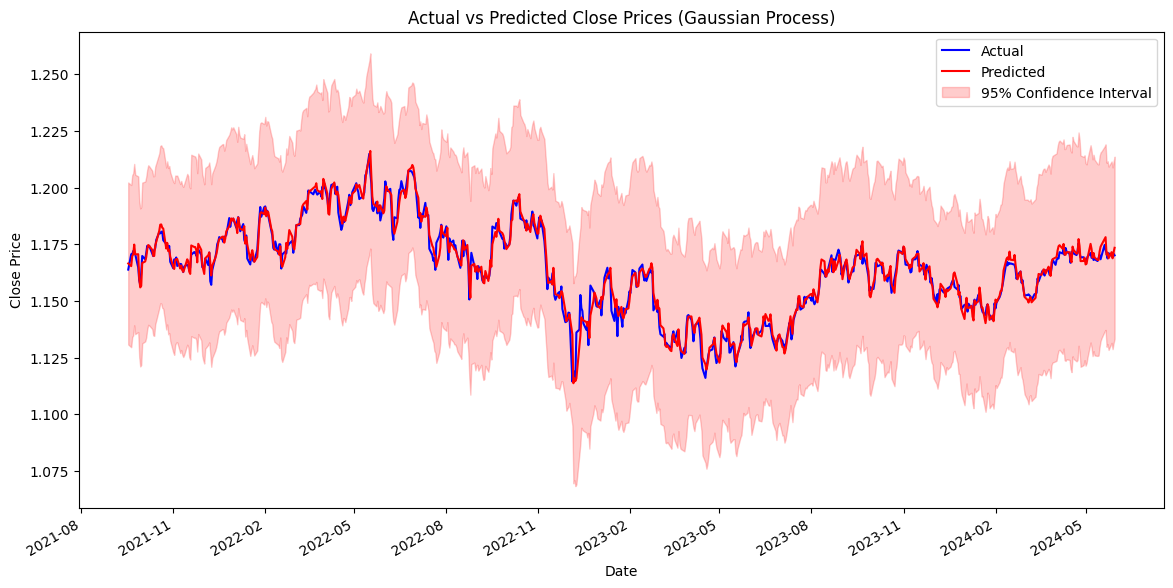

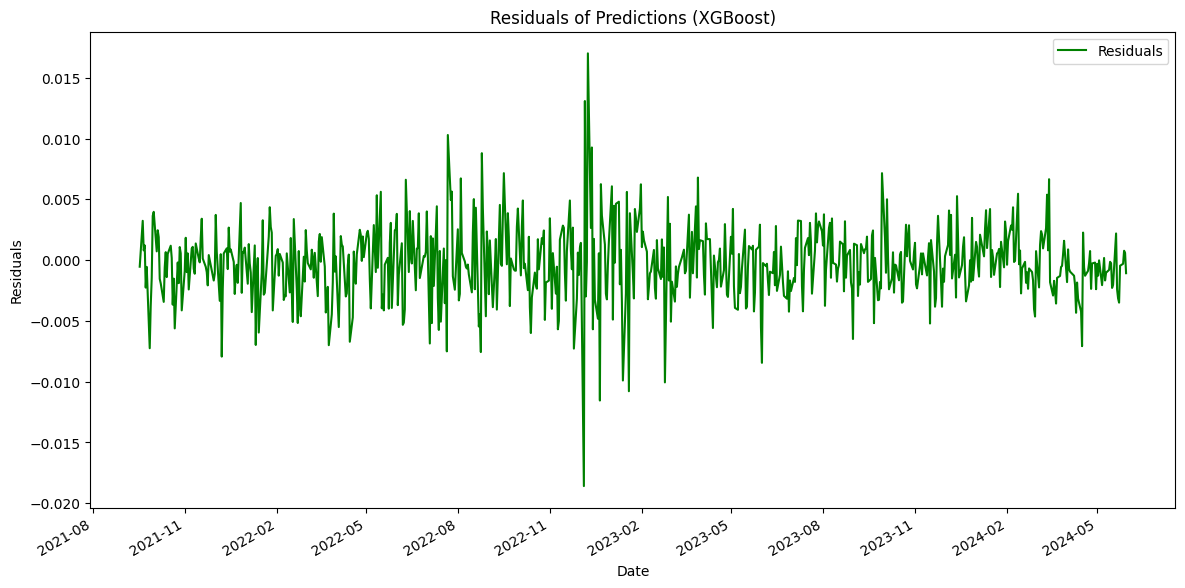

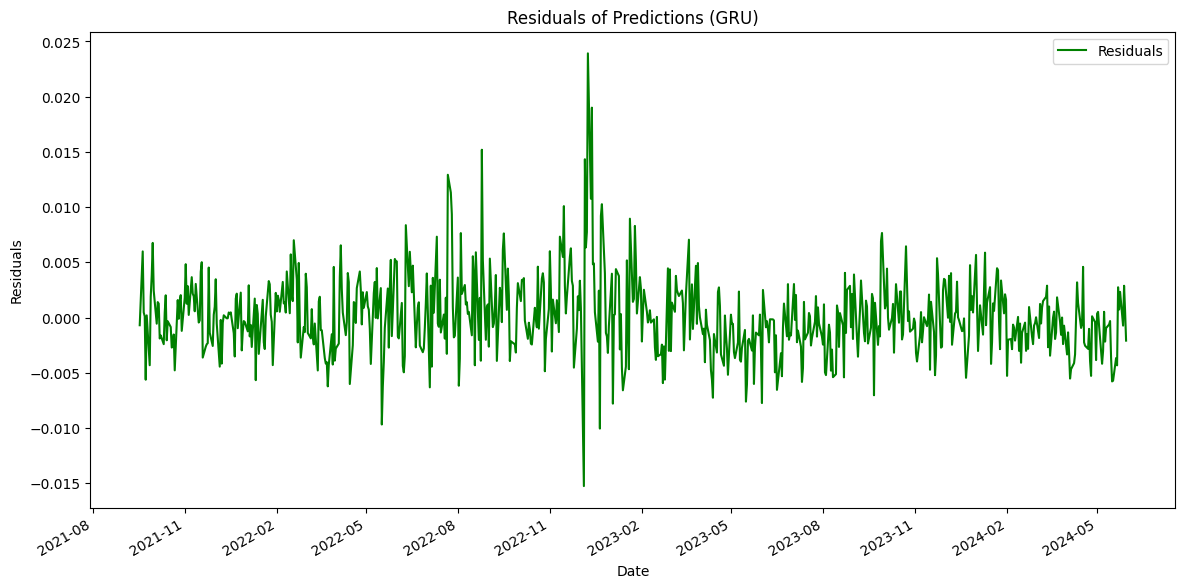

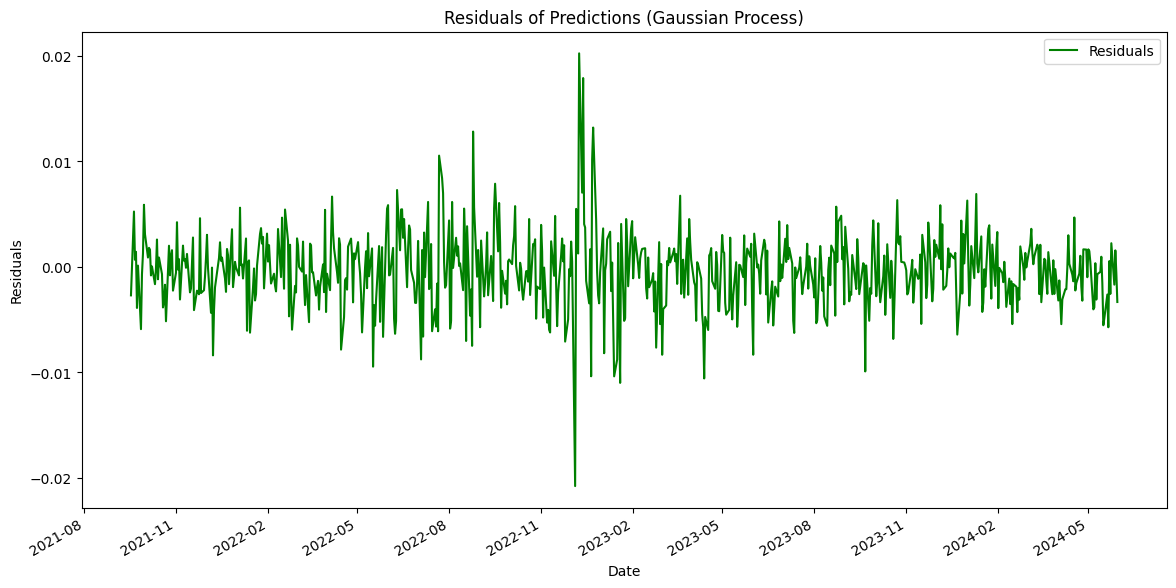

In [72]:
def format_date_axis(ax):
    """
    Format the x-axis to display dates in a readable format.

    Parameters:
    ax (matplotlib.axes.Axes): The axes object to format.
    """
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()

def plot_predictions(dates, y_test_actual, y_pred_actual, model_name):
    """
    Plot actual vs predicted close prices.

    Parameters:
    dates (pd.Series): Dates for the x-axis.
    y_test_actual (np.ndarray): Actual values of the target variable.
    y_pred_actual (np.ndarray): Predicted values of the target variable.
    model_name (str): Name of the model used for predictions.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_test_actual, label='Actual', color='blue')
    plt.plot(dates, y_pred_actual, label='Predicted', color='red')
    plt.title(f'Actual vs Predicted Close Prices ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    format_date_axis(plt.gca())
    plt.show()

def plot_residuals(dates, y_test_actual, y_pred_actual, model_name):
    """
    Plot residuals of predictions.

    Parameters:
    dates (pd.Series): Dates for the x-axis.
    y_test_actual (np.ndarray): Actual values of the target variable.
    y_pred_actual (np.ndarray): Predicted values of the target variable.
    model_name (str): Name of the model used for predictions.
    """
    residuals = y_test_actual - y_pred_actual
    plt.figure(figsize=(14, 7))
    plt.plot(dates, residuals, label='Residuals', color='green')
    plt.title(f'Residuals of Predictions ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend()
    format_date_axis(plt.gca())
    plt.show()

#Plotting gpr prediction separately beacuse
def plot_gpr_predictions(dates, y_test_actual, y_pred_actual, sigma_gpr_test):
    """
    Plot actual vs predicted close prices with 95% confidence interval for Gaussian Process.

    Parameters:
    dates (pd.Series): Dates for the x-axis.
    y_test_actual (np.ndarray): Actual values of the target variable.
    y_pred_actual (np.ndarray): Predicted values of the target variable.
    sigma_gpr_test (np.ndarray): Standard deviation of the predictions.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_test_actual, label='Actual', color='blue')
    plt.plot(dates, y_pred_actual, label='Predicted', color='red')
    plt.fill_between(dates, y_pred_actual.flatten() - 1.96 * sigma_gpr_test, y_pred_actual.flatten() + 1.96 * sigma_gpr_test, color='red', alpha=0.2, label='95% Confidence Interval')
    plt.title('Actual vs Predicted Close Prices (Gaussian Process)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    format_date_axis(plt.gca())
    plt.show()


# plot results
plot_predictions(test_dates, y_test_actual_gru, y_pred_actual_gru, "GRU")
plot_predictions(test_dates, y_test_actual_xgb, y_pred_actual_xgb, "XGBoost")
plot_gpr_predictions(test_dates, y_test_actual_gpr, y_pred_actual_gpr, sigma_gpr_test)

# plot residuals
plot_residuals(test_dates, y_test_actual_xgb, y_pred_actual_xgb, "XGBoost")
plot_residuals(test_dates, y_test_actual_gru, y_pred_actual_gru, "GRU")
plot_residuals(test_dates, y_test_actual_gpr, y_pred_actual_gpr, "Gaussian Process")

Building Trading Strategy

In [ ]:
stock_df_copy.head()

In [ ]:
def generate_simple_signals(predictions, actual, dates):
    """
    Generate simple trading signals based on model predictions.

    Parameters:
    predictions (array-like): Model predictions for the target variable.
    actual (array-like): Actual values of the target variable.
    dates (array-like): Dates corresponding to the target variable values.

    Returns:
    list of tuples: A list of trading signals, each represented as a tuple with the date and 'Buy' or 'Sell' signal.
    """
    signals = [
        (dates[i], 'Buy' if predictions[i + 1] > actual[i] else 'Sell')
        for i in range(len(predictions) - 1)
    ]
    return signals


In [ ]:
# Ensure predictions and actual values are aligned correctly with dates
test_start_index = len(stock_df_copy) - len(y_test_actual)
test_dates = stock_df_copy['Date'].iloc[test_start_index:].reset_index(drop=True)

# Generate predictions for each model
y_pred_actual_gru = y_pred_actual_gru[:len(test_dates)]
y_pred_actual_xgb_test = y_pred_actual_xgb_test[:len(test_dates)]
y_pred_actual_gpr_test = y_pred_actual_gpr_test[:len(test_dates)]

# Generate signals
signals_gru = generate_simple_signals(y_pred_actual_gru, y_test_actual, test_dates)
signals_xgb = generate_simple_signals(y_pred_actual_xgb_test, y_test_actual, test_dates)
signals_gpr = generate_simple_signals(y_pred_actual_gpr_test, y_test_actual, test_dates)

# Function to evaluate strategy returns based on generated signals
def evaluate_strategy(signals, actual_prices, initial_capital=10000):
    """
    Evaluate strategy returns based on generated signals.

    Parameters:
    signals (list of tuples): Trading signals generated.
    actual_prices (array-like): Actual prices corresponding to the signals.
    initial_capital (float): Initial capital for trading.

    Returns:
    float: Final portfolio value after executing the strategy.
    """
    capital = initial_capital
    position = 0  # 1 for holding a position, 0 for no position

    for i, (date, signal) in enumerate(signals):
        if signal == 'Buy' and position == 0:
            position = capital / actual_prices[i]
            capital = 0
        elif signal == 'Sell' and position > 0:
            capital = position * actual_prices[i]
            position = 0

    final_value = capital + (position * actual_prices[-1] if position > 0 else 0)
    return final_value

# Evaluate strategy for each model
final_value_gru = evaluate_strategy(signals_gru, y_test_actual)
final_value_xgb = evaluate_strategy(signals_xgb, y_test_actual)
final_value_gpr = evaluate_strategy(signals_gpr, y_test_actual)

# Print results
print(f'Final portfolio value using GRU model: ${final_value_gru:.2f}')
print(f'Final portfolio value using XGBoost model: ${final_value_xgb:.2f}')
print(f'Final portfolio value using Gaussian Process model: ${final_value_gpr:.2f}')


In [ ]:
# Function to generate simple trading signals based on model predictions
def generate_simple_signals(predictions, actual, dates, stop_loss=0.3, take_profit=0.9):
    """
    Generate simple trading signals based on model predictions with stop-loss and take-profit.

    Parameters:
    predictions (array-like): Model predictions for the target variable.
    actual (array-like): Actual values of the target variable.
    dates (array-like): Dates corresponding to the target variable values.
    stop_loss (float): Stop-loss threshold as a fraction of the buy price.
    take_profit (float): Take-profit threshold as a fraction of the buy price.

    Returns:
    list of tuples: A list of trading signals, each represented as a tuple with the date and 'Buy' or 'Sell' signal.
    """
    signals = []
    position_open = False
    buy_price = None

    for i in range(len(predictions) - 1):
        if predictions[i + 1] > actual[i] and not position_open:
            signals.append((dates[i], 'Buy'))
            position_open = True
            buy_price = actual[i]
        elif predictions[i + 1] < actual[i] and position_open:
            signals.append((dates[i], 'Sell'))
            position_open = False

        # Check for stop-loss and take-profit conditions
        if position_open and buy_price is not None:
            if actual[i] <= buy_price * (1 - stop_loss):
                signals.append((dates[i], 'Stop-Loss'))
                position_open = False
            elif actual[i] >= buy_price * (1 + take_profit):
                signals.append((dates[i], 'Take-Profit'))
                position_open = False

    return signals

# Function to evaluate strategy returns based on generated signals
def evaluate_strategy(signals, actual_prices, dates, initial_capital=10000):
    """
    Evaluate strategy returns based on generated signals with stop-loss and take-profit.

    Parameters:
    signals (list of tuples): Trading signals generated.
    actual_prices (array-like): Actual prices corresponding to the signals.
    initial_capital (float): Initial capital for trading.

    Returns:
    float: Final portfolio value after executing the strategy.
    """
    capital = initial_capital
    position = 0  # Number of shares held

    actual_prices_dict = {date: price for date, price in zip(dates, actual_prices)}

    for date, signal in signals:
        price = actual_prices_dict[date]
        if signal == 'Buy' and position == 0:
            position = capital / price
            capital = 0
        elif signal in ['Sell', 'Stop-Loss', 'Take-Profit'] and position > 0:
            capital = position * price
            position = 0

    final_value = capital + (position * actual_prices[-1] if position > 0 else 0)
    return final_value

# Ensure predictions and actual values are aligned correctly with dates
test_start_index = len(stock_df_copy) - len(y_test_actual)
test_dates = stock_df_copy['Date'].iloc[test_start_index:].reset_index(drop=True)

# Generate predictions for each model
y_pred_actual_gru = y_pred_actual[:len(test_dates)]
y_pred_actual_xgb_test = y_pred_actual_xgb_test[:len(test_dates)]
y_pred_actual_gpr_test = y_pred_actual_gpr_test[:len(test_dates)]

# Generate signals with stop-loss and take-profit
stop_loss = 0.05  # 5% stop-loss
take_profit = 0.1  # 10% take-profit

signals_gru = generate_simple_signals(y_pred_actual_gru, y_test_actual, test_dates, stop_loss, take_profit)
signals_xgb = generate_simple_signals(y_pred_actual_xgb_test, y_test_actual, test_dates, stop_loss, take_profit)
signals_gpr = generate_simple_signals(y_pred_actual_gpr_test, y_test_actual, test_dates, stop_loss, take_profit)

# Evaluate strategy for each model
final_value_gru = evaluate_strategy(signals_gru, y_test_actual, test_dates)
final_value_xgb = evaluate_strategy(signals_xgb, y_test_actual, test_dates)
final_value_gpr = evaluate_strategy(signals_gpr, y_test_actual, test_dates)

# Print results
print(f'Final portfolio value using GRU model: ${final_value_gru:.2f}')
print(f'Final portfolio value using XGBoost model: ${final_value_xgb:.2f}')
print(f'Final portfolio value using Gaussian Process model: ${final_value_gpr:.2f}')


**Using the Daily returns, Sharpe ratio and Maximum draw down to check the profitability and risk-adjusted performance of your trading strategy.**

In [ ]:
def calculate_daily_returns(balance_history):
    """
    Calculate daily returns from balance history.

    Parameters:
    balance_history (list): List of balance history.

    Returns:
    np.ndarray: Array of daily returns.
    """
    returns = np.diff(balance_history) / balance_history[:-1]
    return returns

def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.01):
    """
    Calculate Sharpe Ratio from daily returns.

    Parameters:
    daily_returns (np.ndarray): Array of daily returns.
    risk_free_rate (float): Risk-free rate, default is 0.01.

    Returns:
    float: Sharpe Ratio.
    """
    mean_return = np.mean(daily_returns)
    std_return = np.std(daily_returns)
    sharpe_ratio = (mean_return - risk_free_rate) / std_return
    return sharpe_ratio

def calculate_max_drawdown(balance_history):
    """
    Calculate the maximum drawdown from balance history.

    Parameters:
    balance_history (list): List of balance history.

    Returns:
    float: Maximum drawdown.
    """
    peak = np.maximum.accumulate(balance_history)
    drawdown = (balance_history - peak) / peak
    max_drawdown = np.min(drawdown)
    return max_drawdown

def simulate_and_evaluate_trading_strategy(predictions, actual, dates, stop_loss_pct=0.001, take_profit_pct=0.002):
    """
    Simulate and evaluate a trading strategy with stop loss and take profit.

    Parameters:
    predictions (array-like): Model predictions for the target variable.
    actual (array-like): Actual values of the target variable.
    dates (array-like): Dates corresponding to the target variable values.
    stop_loss_pct (float): Stop loss percentage.
    take_profit_pct (float): Take profit percentage.

    Returns:
    tuple: Final balance, profit, Sharpe ratio, maximum drawdown, balance history, and executed trade dates.
    """
    initial_balance = 10000
    balance = initial_balance
    position_size = 0
    balance_history = []
    executed_trade_dates = []

    for i in range(len(predictions) - 1):
        trade_amount = actual[i]  # Price per unit

        if predictions[i + 1] > actual[i] and balance > trade_amount:
            position_size = int(balance // trade_amount)
            cost = position_size * trade_amount
            balance -= cost
            entry_price = trade_amount
            stop_loss_price = entry_price * (1 - stop_loss_pct)
            take_profit_price = entry_price * (1 + take_profit_pct)
            executed_trade_dates.append(dates[i])

            for j in range(i + 1, len(actual)):
                if actual[j] <= stop_loss_price or actual[j] >= take_profit_price:
                    balance += position_size * actual[j]
                    position_size = 0
                    executed_trade_dates.append(dates[j])
                    break
        elif predictions[i + 1] < actual[i] and position_size > 0:
            balance += position_size * trade_amount
            position_size = 0
            executed_trade_dates.append(dates[i])

        balance_history.append(max(balance + position_size * actual[i], 0))

    final_balance = balance_history[-1] if balance_history else initial_balance
    profit = final_balance - initial_balance
    daily_returns = calculate_daily_returns(balance_history)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    max_drawdown = calculate_max_drawdown(balance_history)

    return final_balance, profit, sharpe_ratio, max_drawdown, balance_history, executed_trade_dates

# Assuming the predictions, actual values, and dates are already available

# Generate signals for each model
signals_gru = generate_simple_signals(y_pred_actual_gru, y_test_actual, test_dates)
signals_xgb = generate_simple_signals(y_pred_actual_xgb_test, y_test_actual, test_dates)
signals_gpr = generate_simple_signals(y_pred_actual_gpr_test, y_test_actual, test_dates)

# Evaluate strategy for each model
results_gru = simulate_and_evaluate_trading_strategy(y_pred_actual_gru, y_test_actual, test_dates)
results_xgb = simulate_and_evaluate_trading_strategy(y_pred_actual_xgb_test, y_test_actual, test_dates)
results_gpr = simulate_and_evaluate_trading_strategy(y_pred_actual_gpr_test, y_test_actual, test_dates)

# Print results
print(f'GRU Model - Final Balance: ${results_gru[0]:.2f}, Profit: ${results_gru[1]:.2f}, Sharpe Ratio: {results_gru[2]:.2f}, Max Drawdown: {results_gru[3]:.2f}')
print(f'XGBoost Model - Final Balance: ${results_xgb[0]:.2f}, Profit: ${results_xgb[1]:.2f}, Sharpe Ratio: {results_xgb[2]:.2f}, Max Drawdown: {results_xgb[3]:.2f}')
print(f'Gaussian Process Model - Final Balance: ${results_gpr[0]:.2f}, Profit: ${results_gpr[1]:.2f}, Sharpe Ratio: {results_gpr[2]:.2f}, Max Drawdown: {results_gpr[3]:.2f}')

# Plot balance history for GRU model
plt.figure(figsize=(14, 7))
plt.plot(results_gru[5], results_gru[4], label='GRU Model')
plt.title('Balance History (GRU Model)')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.legend()
plt.show()

# Plot balance history for XGBoost model
plt.figure(figsize=(14, 7))
plt.plot(results_xgb[5], results_xgb[4], label='XGBoost Model')
plt.title('Balance History (XGBoost Model)')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.legend()
plt.show()

# Plot balance history for Gaussian Process model
plt.figure(figsize=(14, 7))
plt.plot(results_gpr[5], results_gpr[4], label='Gaussian Process Model')
plt.title('Balance History (Gaussian Process Model)')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.legend()
plt.show()


In [ ]:


def simulate_and_evaluate_trading_strategy(predictions, actual, dates, stop_loss_pct=0.001, take_profit_pct=0.002):
    """
    Simulate and evaluate a trading strategy with stop loss and take profit.

    Parameters:
    predictions (array-like): Model predictions for the target variable.
    actual (array-like): Actual values of the target variable.
    dates (array-like): Dates corresponding to the target variable values.
    stop_loss_pct (float): Stop loss percentage.
    take_profit_pct (float): Take profit percentage.

    Returns:
    tuple: Final balance, profit, Sharpe ratio, maximum drawdown, balance history, and executed trade dates.
    """
    initial_balance = 10000
    balance = initial_balance
    position_size = 0
    balance_history = []
    executed_trade_dates = []
    full_dates = []

    for i, prediction in enumerate(predictions[:-1]):
        trade_amount = actual[i]  # Price per unit

        if prediction > actual[i] and balance > trade_amount:  # Buy signal
            position_size = int(balance // trade_amount)
            cost = position_size * trade_amount
            balance -= cost
            entry_price = trade_amount
            stop_loss_price = entry_price * (1 - stop_loss_pct)
            take_profit_price = entry_price * (1 + take_profit_pct)

            for j in range(i + 1, len(actual)):
                if actual[j] <= stop_loss_price or actual[j] >= take_profit_price:
                    balance += position_size * actual[j]
                    position_size = 0
                    executed_trade_dates.append(dates[j])
                    break

        elif prediction < actual[i] and position_size > 0:  # Sell signal
            balance += position_size * trade_amount
            position_size = 0
            executed_trade_dates.append(dates[i])

        balance_history.append(balance + position_size * actual[i])
        full_dates.append(dates[i])

    final_balance = balance_history[-1] if balance_history else initial_balance
    profit = final_balance - initial_balance
    daily_returns = calculate_daily_returns(balance_history)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    max_drawdown = calculate_max_drawdown(balance_history)

    return final_balance, profit, sharpe_ratio, max_drawdown, balance_history, full_dates

def calculate_daily_returns(balance_history):
    """
    Calculate daily returns from balance history.

    Parameters:
    balance_history (list): List of balance history.

    Returns:
    np.ndarray: Array of daily returns.
    """
    returns = np.diff(balance_history) / balance_history[:-1]
    return returns

def calculate_sharpe_ratio(daily_returns, risk_free_rate=0.01):
    """
    Calculate Sharpe Ratio from daily returns.

    Parameters:
    daily_returns (np.ndarray): Array of daily returns.
    risk_free_rate (float): Risk-free rate, default is 0.01.

    Returns:
    float: Sharpe Ratio.
    """
    mean_return = np.mean(daily_returns)
    std_return = np.std(daily_returns)
    sharpe_ratio = (mean_return - risk_free_rate) / std_return
    return sharpe_ratio

def calculate_max_drawdown(balance_history):
    """
    Calculate the maximum drawdown from balance history.

    Parameters:
    balance_history (list): List of balance history.

    Returns:
    float: Maximum drawdown.
    """
    peak = balance_history[0]
    max_drawdown = 0
    for balance in balance_history:
        if balance > peak:
            peak = balance
        drawdown = (peak - balance) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

# Assuming you have already generated your predictions (y_pred_actual_gru, y_pred_actual_xgb_test, y_pred_actual_gpr_test)
# and actual values (y_test_actual) with their corresponding dates (test_dates)

# Evaluate strategy for each model
results_gru = simulate_and_evaluate_trading_strategy(y_pred_actual_gru, y_test_actual, test_dates)
results_xgb = simulate_and_evaluate_trading_strategy(y_pred_actual_xgb_test, y_test_actual, test_dates)
results_gpr = simulate_and_evaluate_trading_strategy(y_pred_actual_gpr_test, y_test_actual, test_dates)

# Plot balance history for GRU model
plt.figure(figsize=(14, 7))
plt.plot(results_gru[5], results_gru[4], label='GRU Model')
plt.title('Balance History (GRU Model)')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.legend()
plt.show()

# Plot balance history for XGBoost model
plt.figure(figsize=(14, 7))
plt.plot(results_xgb[5], results_xgb[4], label='XGBoost Model')
plt.title('Balance History (XGBoost Model)')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.legend()
plt.show()

# Plot balance history for Gaussian Process model
plt.figure(figsize=(14, 7))
plt.plot(results_gpr[5], results_gpr[4], label='Gaussian Process Model')
plt.title('Balance History (Gaussian Process Model)')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.legend()
plt.show()

# Display the final balance, profit, Sharpe ratio, and maximum drawdown for each model
print("GRU Model - Final Balance:", results_gru[0], "Profit:", results_gru[1], "Sharpe Ratio:", results_gru[2], "Max Drawdown:", results_gru[3])
print("XGBoost Model - Final Balance:", results_xgb[0], "Profit:", results_xgb[1], "Sharpe Ratio:", results_xgb[2], "Max Drawdown:", results_xgb[3])
print("Gaussian Process Model - Final Balance:", results_gpr[0], "Profit:", results_gpr[1], "Sharpe Ratio:", results_gpr[2], "Max Drawdown:", results_gpr[3])


In [ ]:
def generate_advanced_signals(df, predictions, stop_loss_pct=0.001, take_profit_pct=0.002):
    """
    Generate advanced trading signals based on predictions and technical indicators.

    Parameters:
    df (pd.DataFrame): DataFrame containing technical indicators and actual prices.
    predictions (array-like): Model predictions for the target variable.
    stop_loss_pct (float): Stop loss percentage.
    take_profit_pct (float): Take profit percentage.

    Returns:
    list of tuples: A list of trading signals, each represented as a tuple with the date and 'Buy' or 'Sell' signal.
    """
    signals = []
    for i in range(len(predictions) - 1):
        if predictions[i + 1] > df['Close'][i] and df['RSI'][i] < 30 and df['MACD_Histogram'][i] > 0:
            signals.append((df['Date'][i], 'Buy'))
        elif predictions[i + 1] < df['Close'][i] and df['RSI'][i] > 70 and df['MACD_Histogram'][i] < 0:
            signals.append((df['Date'][i], 'Sell'))
    return signals

# Generate signals for each model
signals_gru = generate_advanced_signals(stock_df_copy, y_pred_actual_gru)
signals_xgb = generate_advanced_signals(stock_df_copy, y_pred_actual_xgb_test)
signals_gpr = generate_advanced_signals(stock_df_copy, y_pred_actual_gpr_test)

# Simulate and evaluate strategy for each model
results_gru = simulate_and_evaluate_trading_strategy(y_pred_actual_gru, y_test_actual, test_dates)
results_xgb = simulate_and_evaluate_trading_strategy(y_pred_actual_xgb_test, y_test_actual, test_dates)
results_gpr = simulate_and_evaluate_trading_strategy(y_pred_actual_gpr_test, y_test_actual, test_dates)

# Plot balance history for each model
def plot_balance_history(results, model_name):
    plt.figure(figsize=(14, 7))
    plt.plot(results[5], results[4], label=f'{model_name} Model')
    plt.title(f'Balance History ({model_name} Model)')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.legend()
    plt.show()

plot_balance_history(results_gru, 'GRU')
plot_balance_history(results_xgb, 'XGBoost')
plot_balance_history(results_gpr, 'Gaussian Process')

# Display the final balance, profit, Sharpe ratio, and maximum drawdown for each model
print("GRU Model - Final Balance:", results_gru[0], "Profit:", results_gru[1], "Sharpe Ratio:", results_gru[2], "Max Drawdown:", results_gru[3])
print("XGBoost Model - Final Balance:", results_xgb[0], "Profit:", results_xgb[1], "Sharpe Ratio:", results_xgb[2], "Max Drawdown:", results_xgb[3])
print("Gaussian Process Model - Final Balance:", results_gpr[0], "Profit:", results_gpr[1], "Sharpe Ratio:", results_gpr[2], "Max Drawdown:", results_gpr[3])


In [ ]:
def simulate_and_evaluate_optimized_trading(signals, actual, dates, stop_loss_pct=0.01, take_profit_pct=0.02):
    """
    Simulate and evaluate an optimized trading strategy with stop loss and take profit.

    Parameters:
    signals (list of tuples): Trading signals generated by the model.
    actual (array-like): Actual values of the target variable.
    dates (array-like): Dates corresponding to the target variable values.
    stop_loss_pct (float): Stop loss percentage.
    take_profit_pct (float): Take profit percentage.

    Returns:
    tuple: Final balance, profit, Sharpe ratio, maximum drawdown, balance history, and executed trade dates.
    """
    initial_balance = 10000
    balance = initial_balance
    position_size = 0
    balance_history = []
    full_dates = []

    for i, (date, signal) in enumerate(signals):
        trade_amount = actual[i]

        if signal == 'Buy' and balance > trade_amount:
            position_size = int(balance // trade_amount)
            cost = position_size * trade_amount
            balance -= cost
            entry_price = trade_amount
            stop_loss_price = entry_price * (1 - stop_loss_pct)
            take_profit_price = entry_price * (1 + take_profit_pct)

            for j in range(i + 1, len(actual)):
                if actual[j] <= stop_loss_price or actual[j] >= take_profit_price:
                    balance += position_size * actual[j]
                    position_size = 0
                    break
        elif signal == 'Sell' and position_size > 0:
            balance += position_size * trade_amount
            position_size = 0

        balance_history.append(max(balance + position_size * actual[i], 0))
        full_dates.append(date)

    final_balance = balance_history[-1] if balance_history else initial_balance
    profit = final_balance - initial_balance
    daily_returns = calculate_daily_returns(balance_history)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    max_drawdown = calculate_max_drawdown(balance_history)

    return final_balance, profit, sharpe_ratio, max_drawdown, balance_history, full_dates

# Example usage with optimized parameters
results_gru_optimized = simulate_and_evaluate_optimized_trading(signals_gru, y_test_actual, test_dates, stop_loss_pct=0.01, take_profit_pct=0.02)
results_xgb_optimized = simulate_and_evaluate_optimized_trading(signals_xgb, y_test_actual, test_dates, stop_loss_pct=0.01, take_profit_pct=0.02)
results_gpr_optimized = simulate_and_evaluate_optimized_trading(signals_gpr, y_test_actual, test_dates, stop_loss_pct=0.01, take_profit_pct=0.02)

# Display the final balance, profit, Sharpe ratio, and maximum drawdown for each optimized model
print("GRU Model (Optimized) - Final Balance:", results_gru_optimized[0], "Profit:", results_gru_optimized[1], "Sharpe Ratio:", results_gru_optimized[2], "Max Drawdown:", results_gru_optimized[3])
print("XGBoost Model (Optimized) - Final Balance:", results_xgb_optimized[0], "Profit:", results_xgb_optimized[1], "Sharpe Ratio:", results_xgb_optimized[2], "Max Drawdown:", results_xgb_optimized[3])
print("Gaussian Process Model (Optimized) - Final Balance:", results_gpr_optimized[0], "Profit:", results_gpr_optimized[1], "Sharpe Ratio:", results_gpr_optimized[2], "Max Drawdown:", results_gpr_optimized[3])
